# Sat Images Feature Engeenering

Las imágenes son datos almacenados de manera matricial, con tres canales de color en el caso de la característica satImg. Según un análisis humano, es de interés conocer la geografía del lugar, dado que esta puede afectar la propagación de las ondas electrmoagnéticas que en el terreno transportan la información.

La adquisición de las imágenes se realizó con lo anterior en mente. Como tal, la imagen tendrá una considerable cantidad de dimensiones, los lados de la imagen por los tres canales. La relación entre el temaño de la muestra (n) y la dimensión del conjunto de datos (d), se puede ver afectada ante el uso de esta característica.

Es necesario por lo tanto utilizar técnicas de ingeniería de características que permitan reducir el valor de (d). No se abordará esta tarea con técnicas de reducción de dimensionalidad sin embargo, porque durante el proceso de generación y transformación, luego de una breve inspección en algunas imágenes se determinó que existen imágenes anómalas.

La intención del código siguiente es la de encontrar estas anomalías y corregirlas para evitar que confundan los algoritmos de aprendizaje de máquina. Esta detección de anomalías se realizará sobre la característica de imagen satelital transformada por alguna técnica de ingeniería de características. Mientras que reducimos la dimensionalidad con la técnica de ingeniería de características comprobamos su utilidad de acuerdo a su desempeño con los modelos entrenados.

Se utilizan algoritmos de clusterización y de detección de anomalías. Los clusters en sí mismos pudiesen ser tomados como una característica reducida, dependiendo del buen desempeño o no.

In [1]:
#Importando librerias
import os
import sys
sys.path.append('../')
sys.path.append('../../')
import time
import random
import mlflow
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from random import sample
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer, Input
from tensorflow.keras.models import Model
from tensorflow.data.experimental import from_variant
from tensorflow.keras.applications.vgg16 import VGG16
from Python.Style.styles import  *
from Resources.mlTracker import *

In [2]:
#Utilizando diseño base 1
plt.style.use('../../Python/Style/style1.mplstyle')

In [3]:
#Diseño base
mClr = designC['cs']
sClr1 = designC['az']
sClr2 = designC['gr']
sClr2_d = plt.get_cmap('gr-d')(0)
sClr2_d2 = plt.get_cmap('gr-d')(2)
sClr3 = designC['nr']
sClr3_d = plt.get_cmap('nr-d')(0)
sClr3_d2 = plt.get_cmap('nr-d')(2)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120
#plt.rcParams.update({"figure.facecolor" : "FFFFFFFF",'xtick.color': sClr2_d2, 'ytick.color': sClr2_d2, 'axes.edgecolor' : sClr2_d2,'axes.titlecolor': sClr1,
#                    'axes.spines.left': True,'axes.spines.bottom': True,'axes.spines.right': True,'axes.spines.top': True})

In [3]:
#Función para lectura de archivos
def getNames(dataPath, extension):
  fileNames = []
  for f in os.listdir(dataPath):
    name, ext = os.path.splitext(f)
    if ext == extension:
      fileNames.append(os.path.join(dataPath,f))
  return fileNames

In [4]:
#Leyendo nombres de imágenes
fPath = r'../../Data/DataMart/transformedImages/'
imgNames = getNames(fPath, ".jpg")
print("Cantidad de imágenes en carpeta :", len(imgNames))

Cantidad de imágenes en carpeta : 25600


## Muestra aleatoria de imágenes

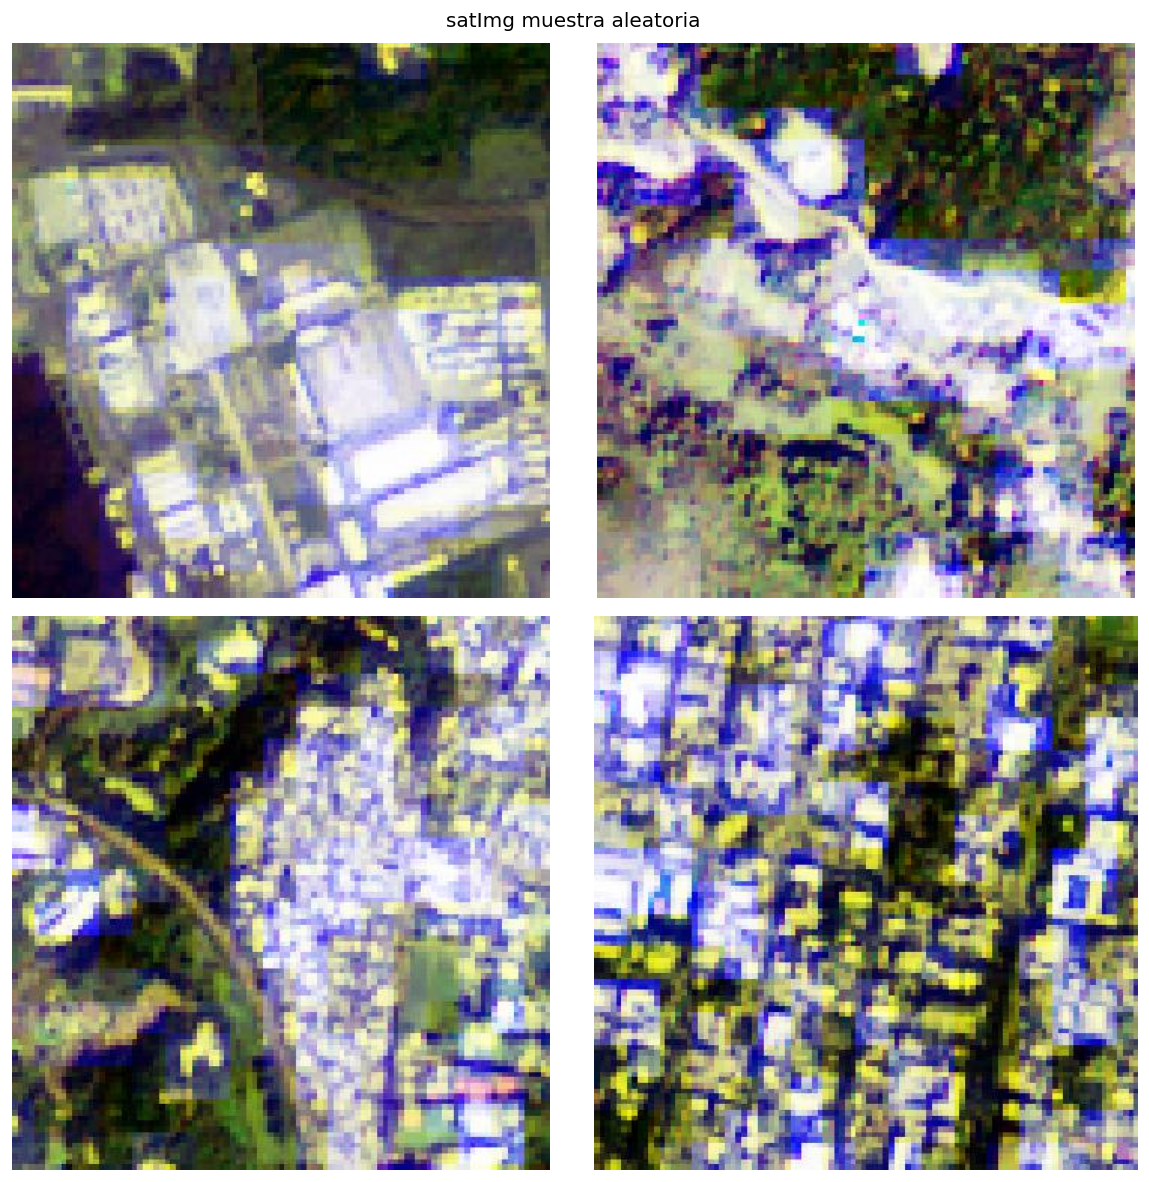

In [5]:
#Muestra principal
random.seed(1010)
rndmImg =  random.sample(imgNames, 4)
timages = [Image.open(path) for path in rndmImg]
# Figura principal
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
#Asignando imágenes
for ax, img in zip(axs.ravel(), timages):
    ax.imshow(img)
    ax.axis('off')

plt.suptitle("satImg muestra aleatoria")
plt.tight_layout()
plt.show()

Por algún motivo existen ciertas entradas de la característica imgSat que tienen información errónea a simple vista. Serán este tipo de imágenes las que se buscarán en la primera parte de este cuaderno, lo que se presenta a continuación.

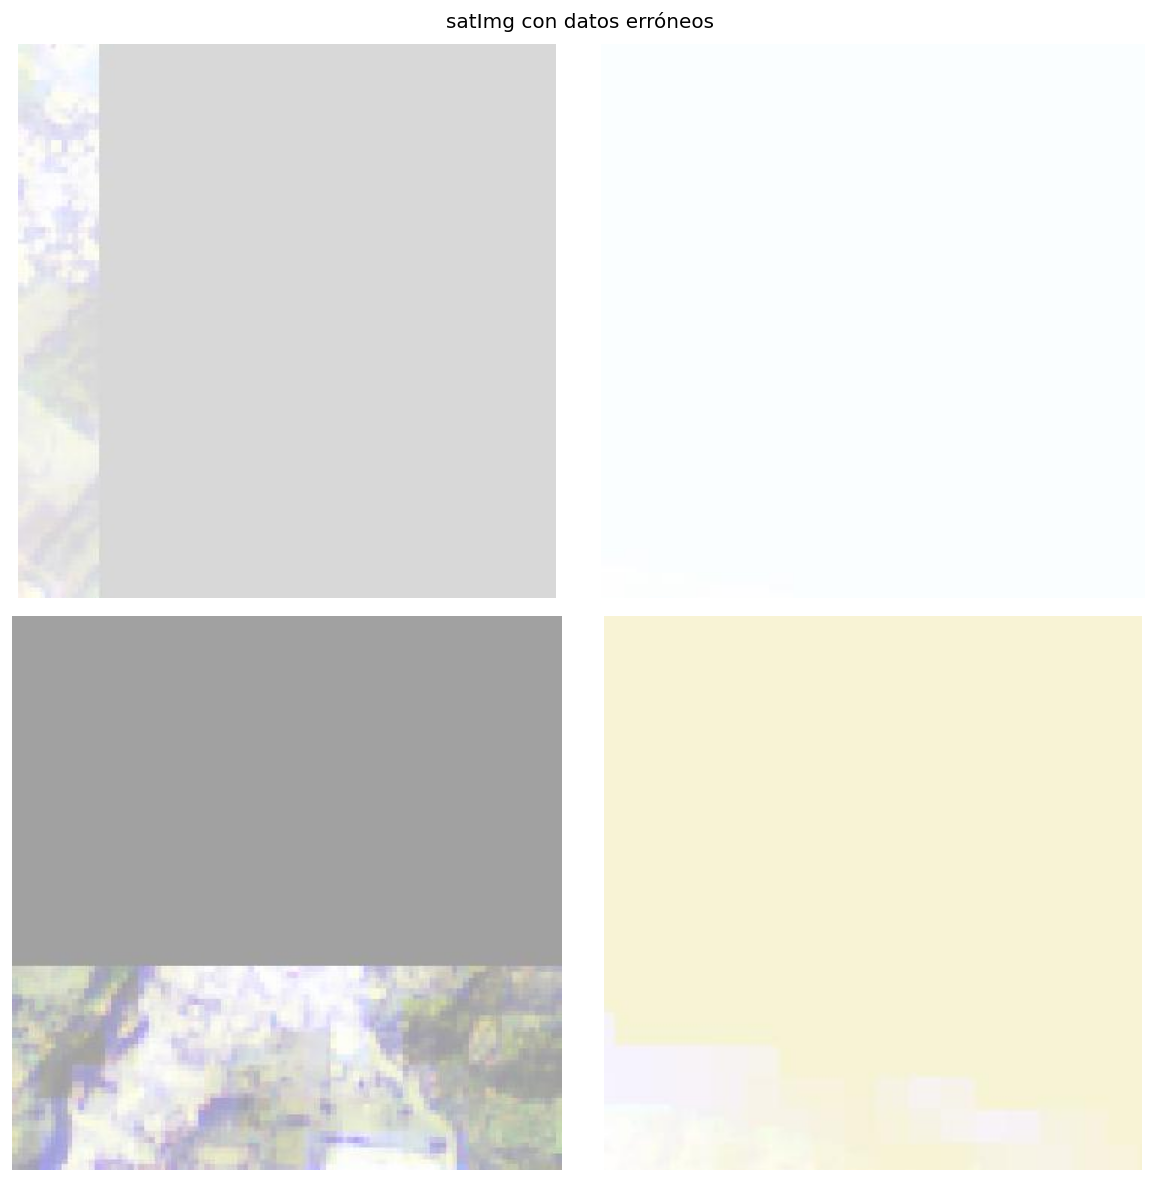

In [6]:
#Visualización
pntImgs = ["satImg-20340.jpg","satImg-20214.jpg","satImg-20124.jpg","satImg-21475.jpg"]
pntImgs = [os.path.join(fPath,i) for i in pntImgs]

images = [Image.open(path) for path in pntImgs]
# Figura principal
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

#Asignando imágenes
for ax, img in zip(axs.ravel(), images):
    ax.imshow(img)
    ax.axis('off')

plt.suptitle("satImg con datos erróneos")
plt.tight_layout()
plt.show()

## Imágenes con excesivas nubes

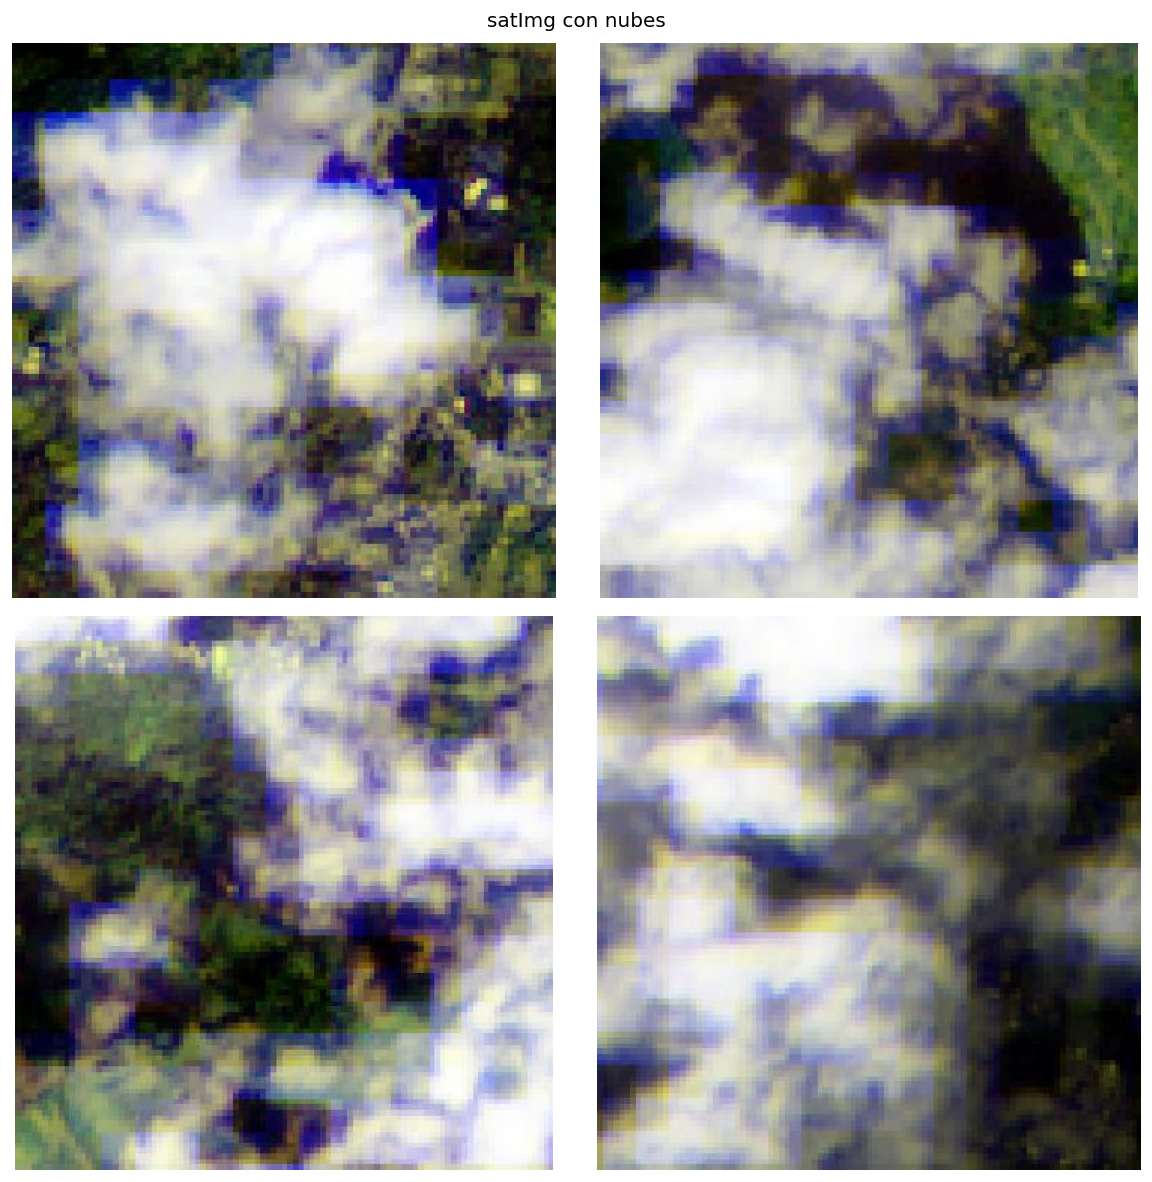

In [7]:
#Visualización
cldImgs = ["satImg-21357.jpg","satImg-19172.jpg","satImg-21372.jpg","satImg-21327.jpg"]
cldImgs = [os.path.join(fPath,i) for i in cldImgs]

images = [Image.open(path) for path in cldImgs]
# Figura principal
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

#Asignando imágenes
for ax, img in zip(axs.ravel(), images):
    ax.imshow(img)
    ax.axis('off')

plt.suptitle("satImg con nubes")
plt.tight_layout()
plt.show()

## Identificando anomalías

Una primera validación se relaciona con el tamaño de las imágenes, en la generación de la característica se creó un cuadrado de 1KM de lado, traducido a pixeles no es una cantidad común a todas las imágenes, por lo que se estimará el temaño según una muestra aleatoria.

In [3]:
#Tamaño de las imágenes
processImg = pd.read_parquet('../../Data/DataMart/imagesData/transImg.parquet')
processImg.dropna(subset = ["imgShape"], inplace = True)
processImg[["x","y","color"]] = processImg["imgShape"].apply(pd.Series)
processImg.describe()

x             y    color
count  25731.000000  25731.000000  25731.0
mean     101.751661     99.189771      3.0
std        0.432058      0.392326      0.0
min      101.000000     98.000000      3.0
25%      102.000000     99.000000      3.0
50%      102.000000     99.000000      3.0
75%      102.000000     99.000000      3.0
max      102.000000    100.000000      3.0

Según lo anterior se decide trabajar el tamaño del cuadro de 99 x 99 pixeles.

La bibliteca tensorflow ofrece ventajas al trabajar con grandes volúmenes de datos, incluso si estos se tienen en forma de imágenes. Luego de cargar los datos con la librería, es el momento de tratar la característica de imgSat y convertirla a un formato distinto, la dimensionalidad de esta característica es alta, a los 99 x 99 pixeles hay que agregar los 3 canales de color.

Una de las técnicas más utilizadas al tratar con imágenes es la utilización de una capa convoluacional previo a una red neuronal para conseguir el objetivo deseado. En este caso se utilizará un modelo preentrenado, de modo que la característica se generará a partir de una red neuronal convolucional con parámetros previamente entrenados.

In [4]:
#Parámetros de imagen
IMAGE_SIZE = (99, 99)
BATCH_SIZE = 100

#Creando dataset desde directorio
dataset = tf.data.Dataset.list_files("../../Data/DataMart/transformedImages/*.*")

def load_and_preprocess_image_with_path(path):
    #Leyendo y decodificando imagen
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    #Redimensionando y normalizando
    image = tf.image.resize(image, IMAGE_SIZE)
    image /= 255.0
    return image, path

#Mapeando función de preprocesamiento
t_dataset_with_path = dataset.map(load_and_preprocess_image_with_path)

#Creando batches del dataset
dataset_with_path = t_dataset_with_path.batch(BATCH_SIZE)

In [10]:
#Obteniendo muestra aleatoria de imágenes
sample_images_with_path = dataset_with_path.shuffle(buffer_size=100).take(1)

#Accediendo a contenido del batch
images, paths = next(iter(sample_images_with_path))


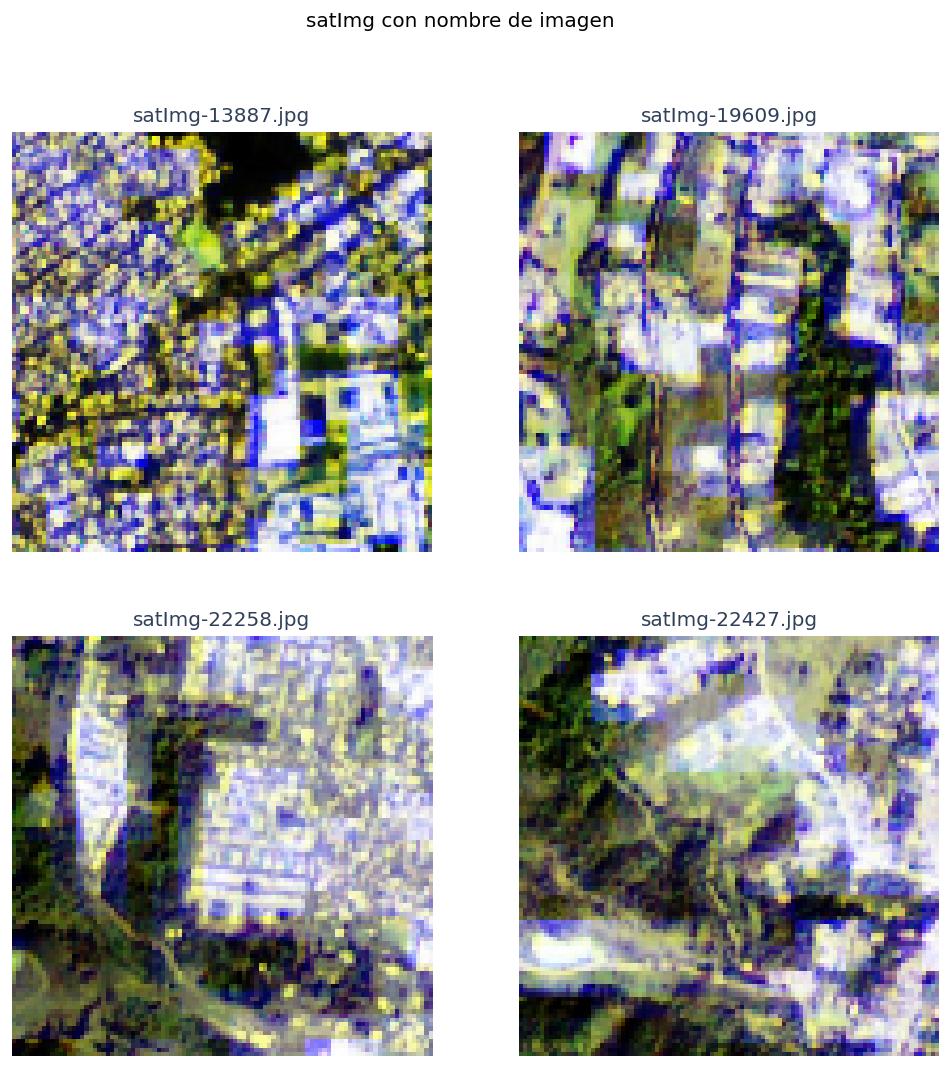

In [11]:
#Visualizando las imágenes con sus nombres
plt.figure(figsize=(10, 10))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow(images[i])
  #Extrayendo solo el nombre de la imagen de la ruta completa
  image_name = os.path.basename(paths[i].numpy().decode("utf-8"))
  plt.title(image_name)
  plt.axis("off")
plt.suptitle("satImg con nombre de imagen")
#Ajustando espacio entre subtramas
plt.show()

In [12]:
#Cantidad de imágenes
batches = tf.data.experimental.cardinality(dataset_with_path).numpy()
total_images = BATCH_SIZE * batches
print("La cantidad aproximada de imágenes en dataset_with_path es {}.".format(total_images))

La cantidad aproximada de imágenes en dataset_with_path es 25600.


## Característica modelo preentrenado

In [5]:

#Utilizando modelo preentrenado
model = VGG16(include_top=False, weights='imagenet', input_shape=(99, 99, 3))

In [6]:
def preprocess_and_extract_features(image_batch):
    # Asumiendo que `image_batch` es un batch de imágenes ya preprocesadas
    features = model.predict(image_batch, verbose = 0)
    return features

In [7]:

# Definir cuántos batches procesar
num_batches_to_process = 256

start_time = time.time()
all_ptr = []
names_ptr = []
batch_count = 0

for image_batch, paths in dataset_with_path.take(num_batches_to_process):
    batch_features = preprocess_and_extract_features(image_batch)
    all_ptr.append(batch_features)
    batch_count += 1
    for path in paths:
        names_ptr.append(path.numpy().decode("utf-8"))
    if batch_count >= num_batches_to_process:
        break

end_time = time.time()
total_time = end_time - start_time
print(f"Procesado {num_batches_to_process} batches en {total_time:.2f} segundos.")

Procesado 256 batches en 363.03 segundos.


In [8]:
# Concatenar todas las características en un solo array NumPy
features_array = np.vstack(all_ptr)

In [9]:
#Aplanando características
pretrained_feature = features_array.reshape((features_array.shape[0], -1))

In [10]:
pretrained_feature.shape

(25600, 4608)

In [11]:
fCols = ["i_{}".format(i) for i in range(1,len(pretrained_feature[0]) + 1)]
df_pretrained = pd.DataFrame(pretrained_feature, columns = fCols)
#df_pretrained.to_parquet("../../Data/DataMart/ImageViews/pretrainedFeature.parquet")
df_pretrained["imagePath"] = names_ptr
#df_pretrained.to_parquet("../../Data/DataMart/ImageViews/pretrainedFeature_wPath.parquet")
df_pretrained.head()

i_1  i_2       i_3       i_4       i_5  i_6  i_7       i_8  i_9  i_10  \
0  0.000000  0.0  0.513477  0.334670  0.000000  0.0  0.0  0.476267  0.0   0.0   
1  1.000430  0.0  2.412691  0.000000  0.260298  0.0  0.0  0.370352  0.0   0.0   
2  0.295802  0.0  1.438389  0.000000  0.328916  0.0  0.0  0.000000  0.0   0.0   
3  0.000000  0.0  0.217859  0.000000  0.072103  0.0  0.0  0.639722  0.0   0.0   
4  0.000000  0.0  0.235932  0.057139  0.000000  0.0  0.0  0.000000  0.0   0.0   

   ...    i_4600    i_4601    i_4602    i_4603    i_4604    i_4605    i_4606  \
0  ...  0.000000  0.722295  0.000000  0.090285  0.273254  0.000000  0.000000   
1  ...  0.000000  0.804221  0.000000  0.000000  0.079806  0.000000  0.208007   
2  ...  0.000000  1.054934  0.000000  0.032163  0.000000  0.000000  0.157842   
3  ...  0.000000  1.270787  0.254821  0.156778  0.000000  0.000000  0.054366   
4  ...  0.101633  0.207495  0.000000  0.419611  0.401117  0.114558  0.000000   

     i_4607  i_4608                                          imagePath  
0  0.210411     0.0  ../../Data/DataMart/transformedImages/satImg-1...  
1  0.442814     0.0  ../../Data/DataMart/transformedImages/satImg-1...  
2  0.365722     0.0  ../../Data/DataMart/transformedImages/satImg-2...  
3  0.429069     0.0  ../../Data/DataMart/transformedImages/satImg-1...  
4  0.503336     0.0  ../../Data/DataMart/transformedImages/satImg-3...  

[5 rows x 4609 columns]

In [4]:
#Leyendo característica pre-entrenada
df_pretrained = pd.read_parquet("../../Data/DataMart/ImageViews/pretrainedFeature_wPath.parquet")
pretrained_feature = df_pretrained.drop(columns = ["imagePath"]).values
names_ptr = df_pretrained["imagePath"].values

### Clusterización con pretrained feature

In [5]:
#Ajustando modelo
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=1010)
pretrained_clusters = kmeans.fit_predict(pretrained_feature)


/Users/victor.borrayo/anaconda3/envs/Tesis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [6]:

def mostrar_imagenes_cluster(imagenes_cluster, numero_cluster, base_title = "Cluster de imágenes"):
    #Validando imagenes en muestra
    tempDf = pd.DataFrame(imagenes_cluster, columns = ["imgName","cluster"])
    tempDf = tempDf[tempDf["cluster"] == numero_cluster]
    imagenes_cluster = tempDf.values.tolist()
    if len(imagenes_cluster) > 4:
        imagenes_cluster = sample(imagenes_cluster, 4)

    plt.figure(figsize=(10, 10))

    for i, (image_name, _) in enumerate(imagenes_cluster[:4]):
        ax = plt.subplot(2, 2, i + 1)
        #Apuntando a directorio
        image_path = f"../../Data/DataMart/transformedImages/{image_name}"
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (99, 99))
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(image_name)
        plt.axis("off")
    plt.suptitle(f"{base_title} {numero_cluster}")
    plt.show()

In [ ]:
#Ajustando names_ptr
names_ptr = [i.split("/")[-1] for i in names_ptr]
names_ptr

In [8]:
#Creando pretrained_clusters
image_cluster_ptr = list(zip(names_ptr, pretrained_clusters))

<AxesSubplot: title={'center': 'Clusters Kmeans Preentrenado - k=5'}>

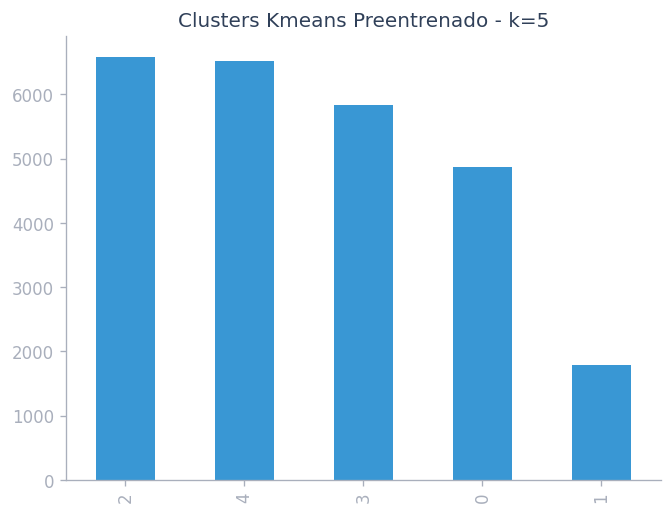

In [9]:
#Visualizando histograma de clusters pretrained feature
tdf_ptr = pd.DataFrame(image_cluster_ptr, columns = ["imgName","cluster"])
tdf_ptr["cluster"].value_counts().plot(kind = "bar", color=mClr, title="Clusters Kmeans Preentrenado - k=5")

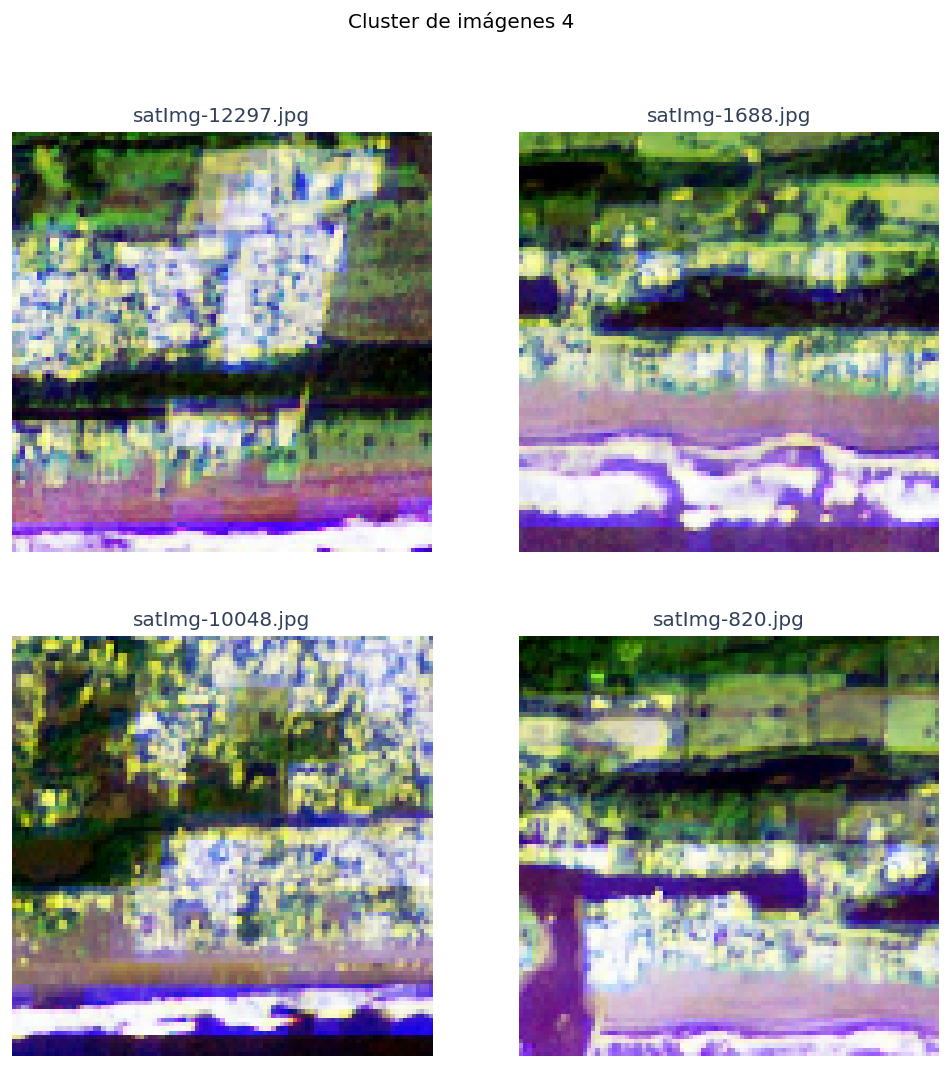

In [79]:
mostrar_imagenes_cluster(image_cluster_ptr, 4)

### Encontrando K óptimo para pretreined feature

In [ ]:
mlflow.set_experiment("OptimalK_2")

#Probando con 2 a 10 clusters
k_values = range(2, 51)
for k in k_values:
    currentTime = currentTime = datetime.now().strftime(RUN_BASE_FORMAT)
    mlflow.start_run(run_name = currentTime)
    kmeans = KMeans(n_clusters=k, random_state=1010)
    kmeans.fit(flattened_features)
    mlflow.log_param("k", k)
    mlflow.log_metric("inertia", kmeans.inertia_)
    mlflow.log_metric("silhouette", silhouette_score(flattened_features, kmeans.labels_))
    mlflow.end_run()

In [17]:
#Obteniendo datos de ejecución
experiment_id = mlflow.get_experiment_by_name("OptimalK_2").experiment_id
runs = mlflow.search_runs(experiment_ids=experiment_id)

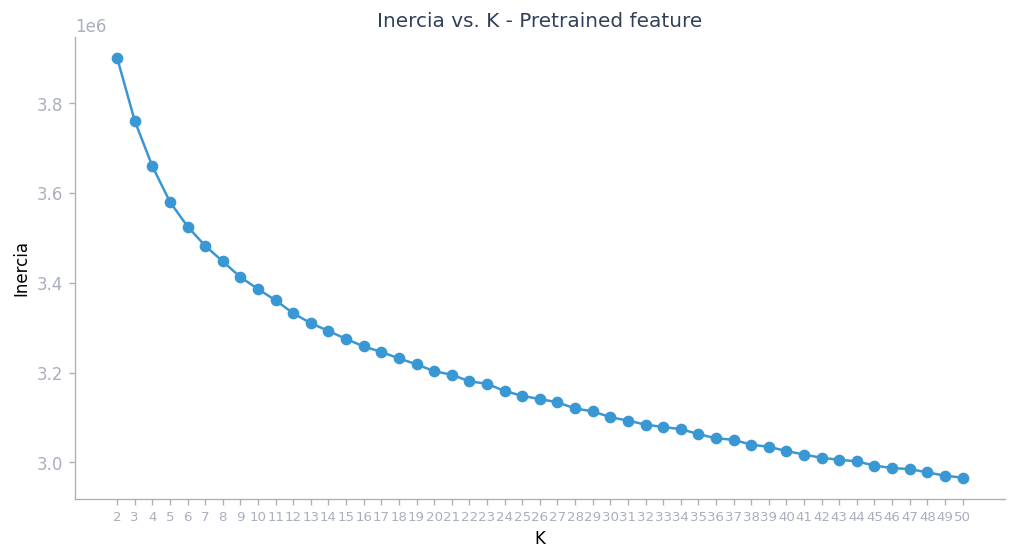

In [18]:
runs["params.k"] = runs["params.k"].astype(int)
runs = runs.sort_values(by="params.k")
k_values = runs["params.k"]
inertia_values = runs["metrics.inertia"]
#Graficando inercia
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_values, marker="o", color = mClr)
plt.title("Inercia vs. K - Pretrained feature")
plt.xlabel("K")
plt.ylabel("Inercia")
kticks = [i for i in k_values if i % 2 == 0]
plt.xticks(fontsize=8)
plt.xticks(k_values)
plt.show()

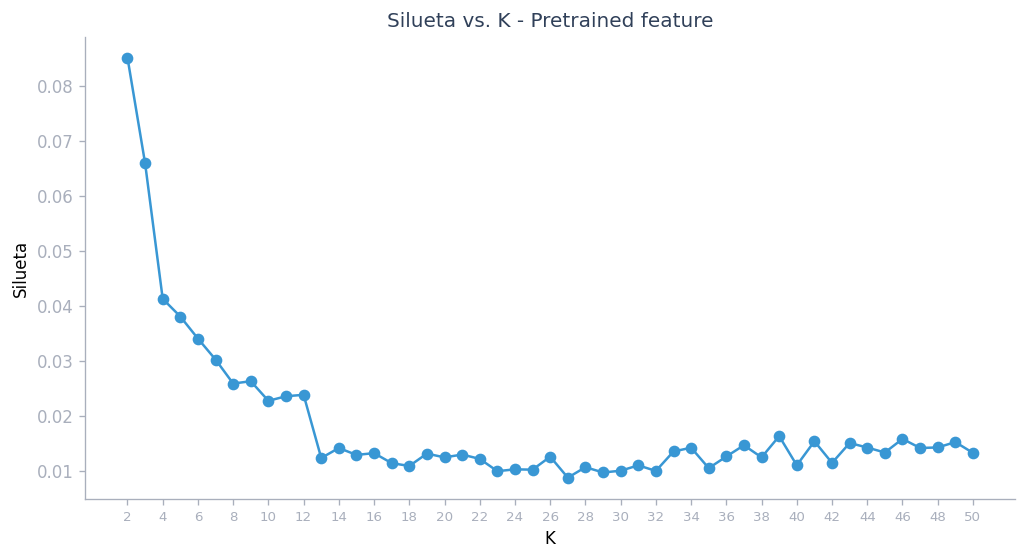

In [19]:
runs["params.k"] = runs["params.k"].astype(int)
runs = runs.sort_values(by="params.k")
k_values = runs["params.k"]
inertia_values = runs["metrics.silhouette"]
#Graficando silueta
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_values, marker="o", color = mClr)
plt.title("Silueta vs. K - Pretrained feature")
plt.xlabel("K")
plt.ylabel("Silueta")
kticks = [i for i in k_values if i % 2 == 0]
plt.xticks(fontsize=8)
plt.xticks(kticks)
plt.show()

El método del codo o "elbow" en inglés, pretende identificar un valor adecuado de K en el punto donde no hay una mejora significativa en la reducción de la inercia conforme sigue aumentando K. Sin embargo, tras entrenar modelos con valores desde k igual a 2 hasta k igual a 50, no se identifica claramente tal punto de inflexión.

En cuanto a la métrica, "silueta", calcula la silueta media de todo el cluster. Este valor está entre 0 y 1, siendo valores cercanos a 1 indicativo de correcta asignación de cluster y -1 una imprecisa, cuando menos. En el caso de los modelos entrenados tienden a 0, lo que puede implicar superposición de clusters.

Más allá de eso, la confirmación visual esperada no se ha alcanzado, menos aún la separación de las anomalías en uno o más clusters. Se elije k = 12 para realizar el siguiente análisis.

In [ ]:
#Ajustando modelo
n_clusters = 12
kmeans_ptr = KMeans(n_clusters=n_clusters, random_state=1010)
pretrained_clusters = kmeans_ptr.fit_predict(pretrained_feature)

In [11]:
#Asociando etiquetas con nombre de imagen
image_cluster_ptr = list(zip(names_ptr, pretrained_clusters))

<AxesSubplot: title={'center': 'Clusters Kmeans Preentrenado - k=12'}>

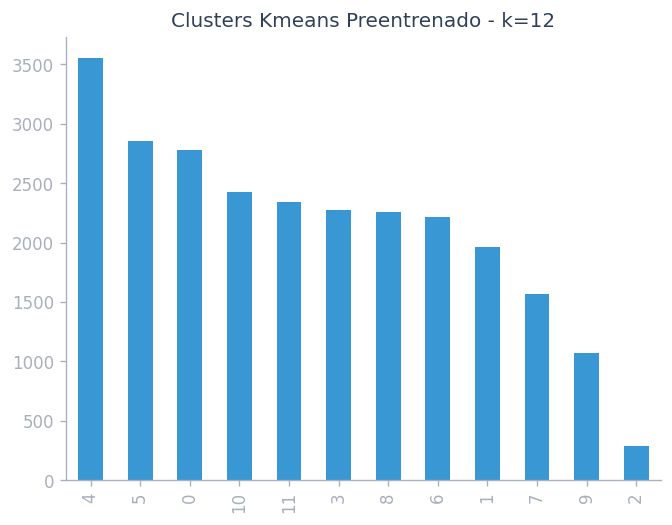

In [12]:
#Visualizando histograma de clusters
tdf_ptr = pd.DataFrame(image_cluster_ptr, columns = ["imgName","cluster"])
tdf_ptr["cluster"].value_counts().plot(kind = "bar", color = mClr, title="Clusters Kmeans Preentrenado - k=12")

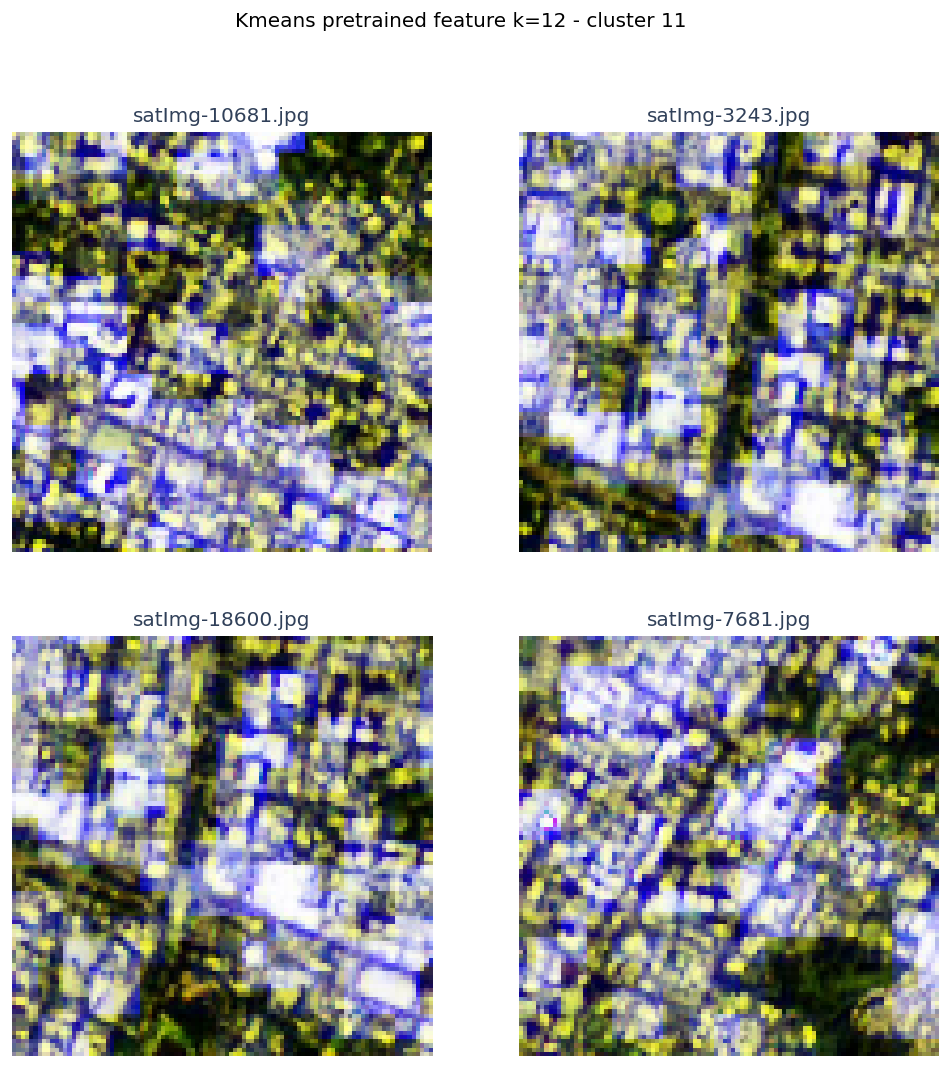

In [45]:
mostrar_imagenes_cluster(image_cluster_ptr, 11, "Kmeans pretrained feature k=12 - cluster")

In [27]:
#Guardando clusters
tdf_ptr.to_parquet("../../Data/DataMart/ImageViews/pretrainedClusters.parquet")
tdf_ptr.to_csv("../../Data/DataMart/ImageViews/pretrainedClusters.csv", index = False)
tdf_ptr.head()

imgName  cluster
0  satImg-14370.jpg        0
1  satImg-19765.jpg        5
2  satImg-23217.jpg        5
3   satImg-1174.jpg        5
4   satImg-3355.jpg        3

In [ ]:
#Guardando modelo
mlflow.set_experiment("FE-Models")
with mlflow.start_run(run_name = "KmeansPretrained"):

    mlflow.sklearn.log_model(kmeans_ptr, "KmeansPretrained")
    mlflow.log_param("n_clusters", n_clusters)
    mlflow.log_param("random_state", 1010)
    mlflow.log_param("features", "pretrained")
    mlflow.log_param("k", 12)
    mlflow.log_param("inertia", kmeans_ptr.inertia_)
    mlflow.log_param("silhouette", silhouette_score(pretrained_feature, kmeans_ptr.labels_))

    mlflow.end_run()

In [46]:
#Lista de anomalías cluster 2
anomalies_cluster_2_ptr = tdf_ptr[tdf_ptr["cluster"] == 2]["imgName"].values.tolist()

Con el cluster 8 se consigue aislar las anomalías, lo que implica que tanto la característica de imágenes transformadas con el modelo preentrenado podría ser apta para su uso en los modelos, a su vez los clusters mismos pueden ser utilizados como una característica.

## Transformando característica con red convolucional

A pesar del modelo preentrenado, pareció necesario el uso de una red convolucional no preentrenada. De modo que a continuación se muestran los resultados.

In [155]:
#Aplicando etapa convolucional a imágenes
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(99, 99, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu')
])
feature_extractor = models.Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [ ]:
#Aplicando red neuronal convolucional y seleccionando el resultado de aplanar la etapa convolucional

now = datetime.now()
currentTime = now.strftime(RUN_BASE_FORMAT)
mlflow.set_experiment("CNNFeatures")
mlflow.start_run(run_name = currentTime)
try:
    cnn_features = []
    names_cnn = []

    for batch_images, paths in dataset_with_path:
        features = feature_extractor.predict(batch_images)
        cnn_features.append(features.reshape(features.shape[0], -1))
        for path in paths:
            names_cnn.append(path.numpy().decode("utf-8").split("/")[-1])

except Exception as e:
    print("Error en la extracción de características")
    print(e)
    mlflow.log_param("Message","Error en la extracción de características")
    mlflow.end_run()


mlflow.log_param("Message", "Característica generada")
mlflow.end_run()

In [157]:
#Obteniendo características como un solo array
cnn_features_array = np.vstack(cnn_features)
cnn_features_flatten = cnn_features_array.reshape((cnn_features_array.shape[0], -1))
cnn_features_flatten.shape

(25600, 12800)

In [158]:
#Guardando cnn features como df
cnnCols = ["i_{}".format(i) for i in range(1,len(cnn_features_flatten[0]) + 1)]
dfCNNFlatten = pd.DataFrame(cnn_features_flatten, columns = cnnCols)
#dfCNNFlatten.to_parquet("../../Data/DataMart/ImageViews/cnnFlattenPTM.parquet")
dfCNNFlatten["imagePath"] = names_cnn
#dfCNNFlatten.to_parquet("../../Data/DataMart/ImageViews/cnnFlattenPTM_wPath.parquet")
dfCNNFlatten.head()

i_1  i_2       i_3       i_4       i_5       i_6       i_7       i_8  \
0  0.112556  0.0  0.052285  0.044402  0.027752  0.146133  0.003627  0.018953   
1  0.133696  0.0  0.036918  0.078732  0.016228  0.071234  0.010941  0.117337   
2  0.051831  0.0  0.070615  0.050790  0.009782  0.155596  0.009553  0.007062   
3  0.050644  0.0  0.007833  0.059035  0.014074  0.034372  0.008627  0.065270   
4  0.122856  0.0  0.107972  0.144119  0.008227  0.126358  0.000000  0.043304   

   i_9      i_10  ...   i_12792   i_12793  i_12794   i_12795   i_12796  \
0  0.0  0.039753  ...  0.093950  0.000000      0.0  0.000000  0.182919   
1  0.0  0.042311  ...  0.091456  0.009509      0.0  0.000000  0.169920   
2  0.0  0.037678  ...  0.071266  0.000000      0.0  0.009210  0.209196   
3  0.0  0.000000  ...  0.025806  0.000000      0.0  0.000000  0.142250   
4  0.0  0.038443  ...  0.091877  0.000000      0.0  0.027949  0.185868   

    i_12797   i_12798  i_12799   i_12800         imagePath  
0  0.083939  0.217357      0.0  0.099865  satImg-16543.jpg  
1  0.091662  0.143152      0.0  0.097552  satImg-13864.jpg  
2  0.035465  0.242723      0.0  0.073117   satImg-8512.jpg  
3  0.065158  0.204113      0.0  0.057264  satImg-19250.jpg  
4  0.073541  0.172014      0.0  0.070632  satImg-18488.jpg  

[5 rows x 12801 columns]

In [13]:
#Leyendo característica cnn
dfCNNFlatten = pd.read_parquet("../../Data/DataMart/ImageViews/cnnFlattenPTM_wPath.parquet")
cnn_features_flatten = dfCNNFlatten.drop(columns = ["imagePath"]).values
names_cnn = dfCNNFlatten["imagePath"].values

In [165]:
#Entrenando knn con características de cnn
mlflow.set_experiment("CNN-KMeans")
currentTime = now.strftime(RUN_BASE_FORMAT)
mlflow.start_run(run_name = currentTime)

k = 3
kmeans_cnn = KMeans(n_clusters=k, random_state=1010)
clusters_cnn = kmeans_cnn.fit_predict(cnn_features_flatten)

mlflow.log_param("k", k)
mlflow.log_metric("inertia", kmeans_cnn.inertia_)
mlflow.log_metric("silhouette", silhouette_score(cnn_features_flatten, kmeans_cnn.labels_))
mlflow.end_run()


/Users/victor.borrayo/anaconda3/envs/Tesis/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [164]:
mlflow.end_run()

In [183]:
#Imagecluster cnn
image_cluster_cnn = list(zip(names_cnn, clusters_cnn))


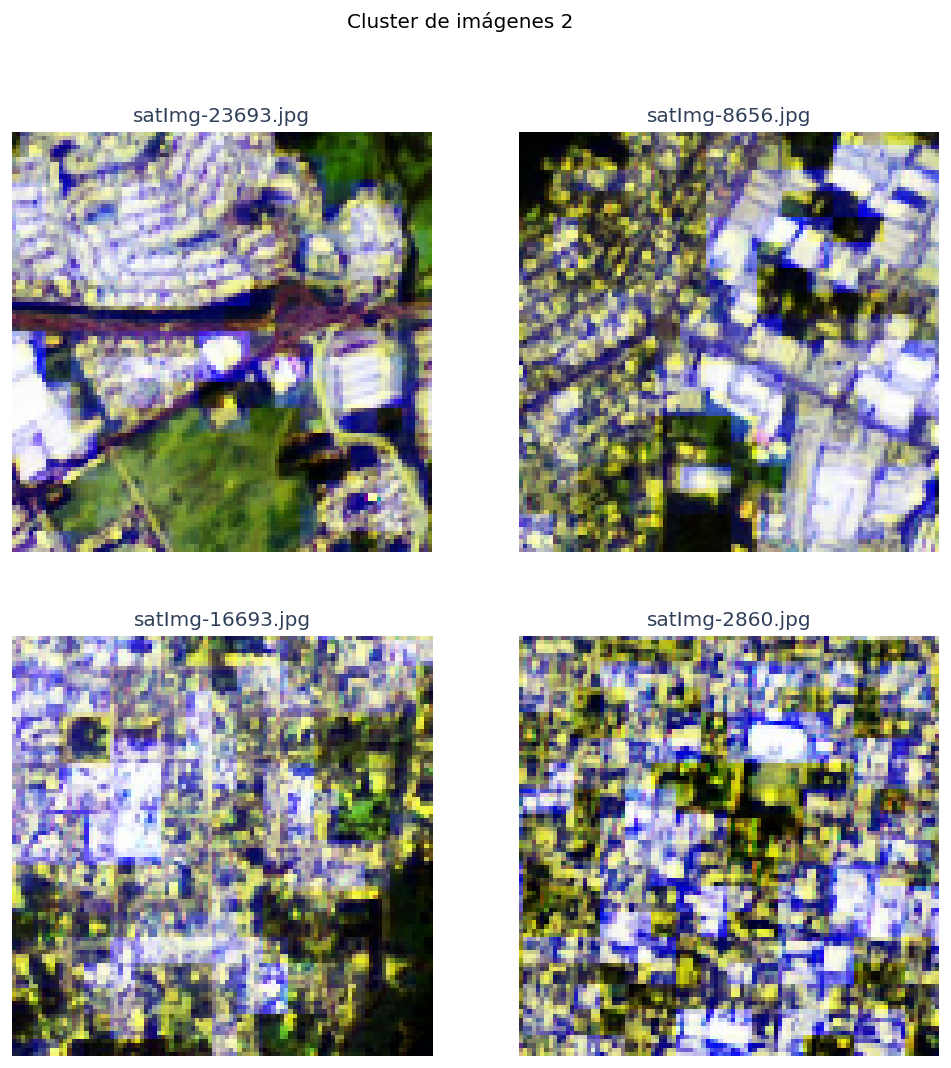

In [196]:
mostrar_imagenes_cluster(image_cluster_cnn, 2)

### Encontrando K óptimo para cnn

In [ ]:
mlflow.set_experiment("OptimalK_CNN")

#Probando con K de 2 a 50 clusters cada 2
k_values = range(2, 51, 2)
for k in k_values:
    currentTime = currentTime = datetime.now().strftime(RUN_BASE_FORMAT)
    mlflow.start_run(run_name = currentTime)
    kmeans = KMeans(n_clusters=k, random_state=1010)
    kmeans.fit(cnn_features_flatten)
    mlflow.log_param("k", k)
    mlflow.log_metric("inertia", kmeans.inertia_)
    mlflow.log_metric("silhouette", silhouette_score(cnn_features_flatten, kmeans.labels_))
    mlflow.end_run()
    

In [14]:
#Obteniendo datos de ejecución
experiment_id = mlflow.get_experiment_by_name("OptimalK_CNN").experiment_id
runs_cnn = mlflow.search_runs(experiment_ids=experiment_id)


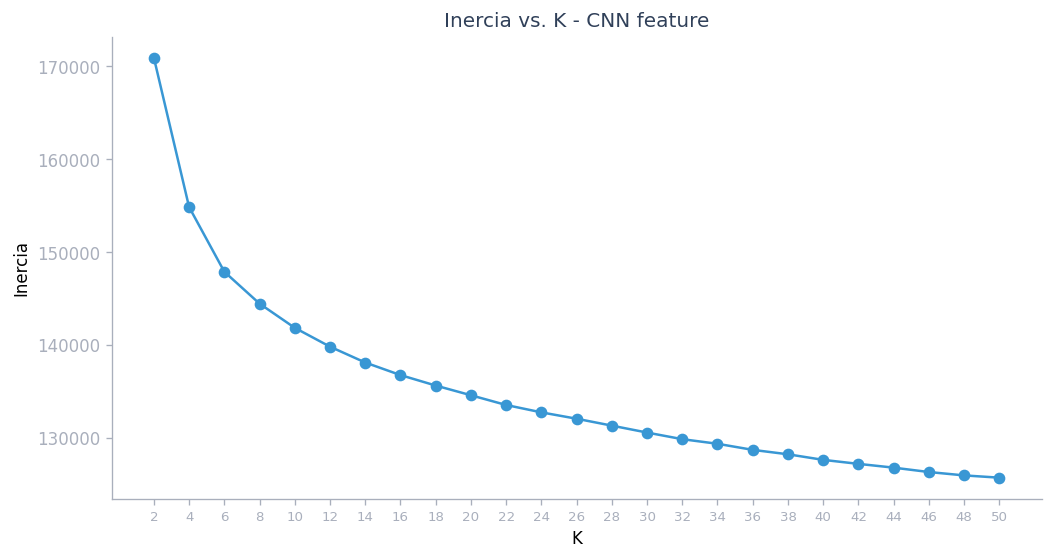

In [15]:

runs_cnn["params.k"] = runs_cnn["params.k"].astype(int)
runs_cnn = runs_cnn.sort_values(by="params.k")
k_values = runs_cnn["params.k"]
inertia_values = runs_cnn["metrics.inertia"]
#Graficando inercia
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_values, marker="o", color = mClr)
plt.title("Inercia vs. K - CNN feature")
plt.xlabel("K")
plt.ylabel("Inercia")
kticks = [i for i in k_values if i % 2 == 0]
plt.xticks(fontsize=8)
plt.xticks(k_values)
plt.show()

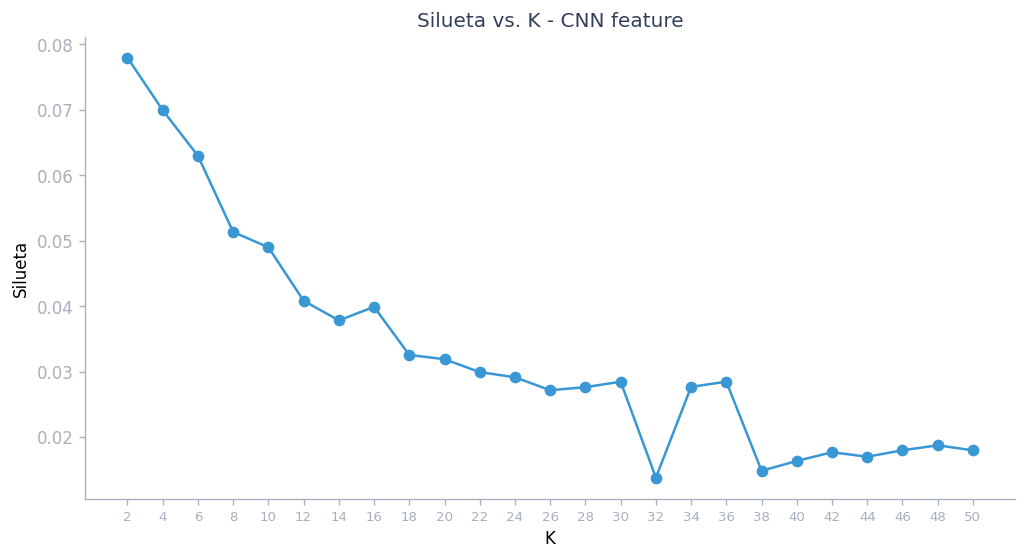

In [16]:
runs_cnn["params.k"] = runs_cnn["params.k"].astype(int)
runs_cnn = runs_cnn.sort_values(by="params.k")
k_values = runs_cnn["params.k"]
inertia_values = runs_cnn["metrics.silhouette"]
#Graficando inercia
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_values, marker="o", color = mClr)
plt.title("Silueta vs. K - CNN feature")
plt.xlabel("K")
plt.ylabel("Silueta")
kticks = [i for i in k_values if i % 2 == 0]
plt.xticks(fontsize=8)
plt.xticks(kticks)
plt.show()

In [ ]:
#Entrenando knn con características de cnn con K seleccionado

k_cnn = 16
kmeans_cnn = KMeans(n_clusters=k_cnn, random_state=1010)
clusters_cnn = kmeans_cnn.fit_predict(cnn_features_flatten)

In [21]:
#Cluster de imagenes cnn
image_cluster_cnn = list(zip(names_cnn, clusters_cnn))

<AxesSubplot: title={'center': 'Clusters Kmeans CNN - k=16'}>

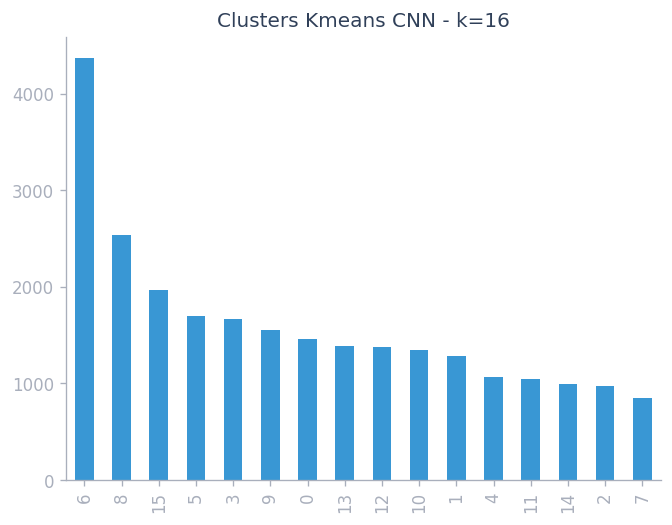

In [22]:
#Visualizando histograma de clusters
tdf_cnn = pd.DataFrame(image_cluster_cnn, columns = ["imgName","cluster"])
tdf_cnn["cluster"].value_counts().plot(kind = "bar", color = mClr, title="Clusters Kmeans CNN - k=16")

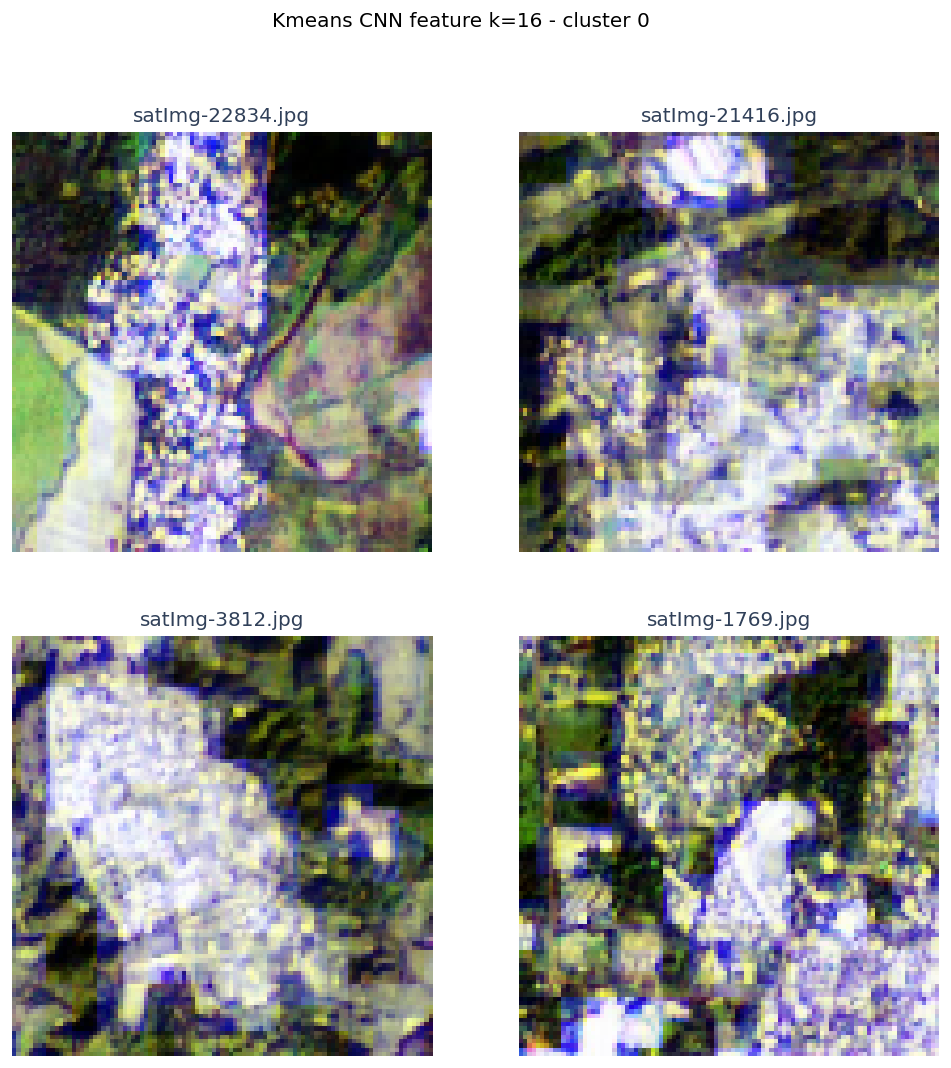

In [278]:
#Visualizando clusters de CNN
mostrar_imagenes_cluster(image_cluster_cnn, 0, "Kmeans CNN feature k=16 - cluster")

#### Aplicando detección de anomalías con característica CNN

In [258]:
#Detectando anomalías con Isolation Forest
isolation_forest_cnn = IsolationForest(contamination=0.01)
isolation_forest_cnn.fit(cnn_features_flatten)

anomalies_cnn = isolation_forest_cnn.predict(cnn_features_flatten)

In [259]:
#Image cluster cnn con anomalías
image_cluster_cnn_anomalies = list(zip(names_cnn, anomalies_cnn))

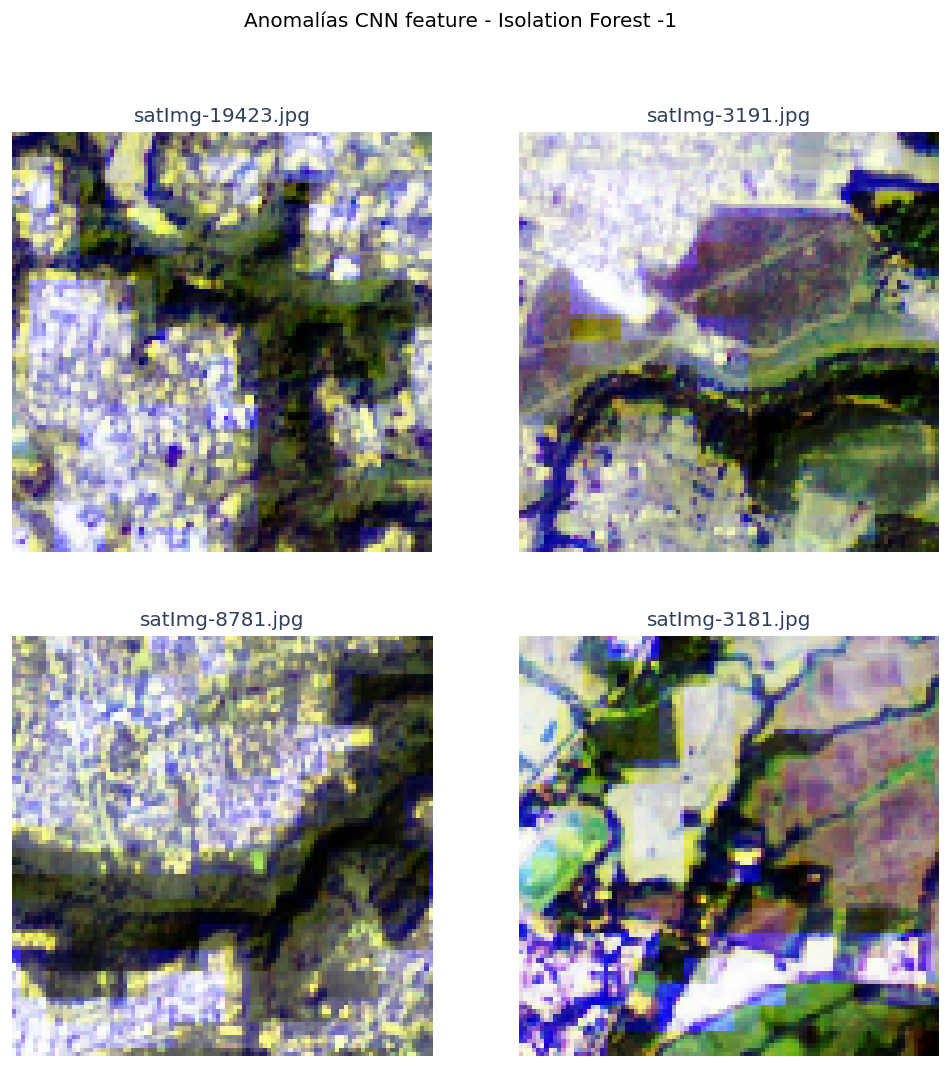

In [269]:
#Visualizando anomalías
mostrar_imagenes_cluster(image_cluster_cnn_anomalies, -1, "Anomalías CNN feature - Isolation Forest")

## Visualizando gráficas conjuntas

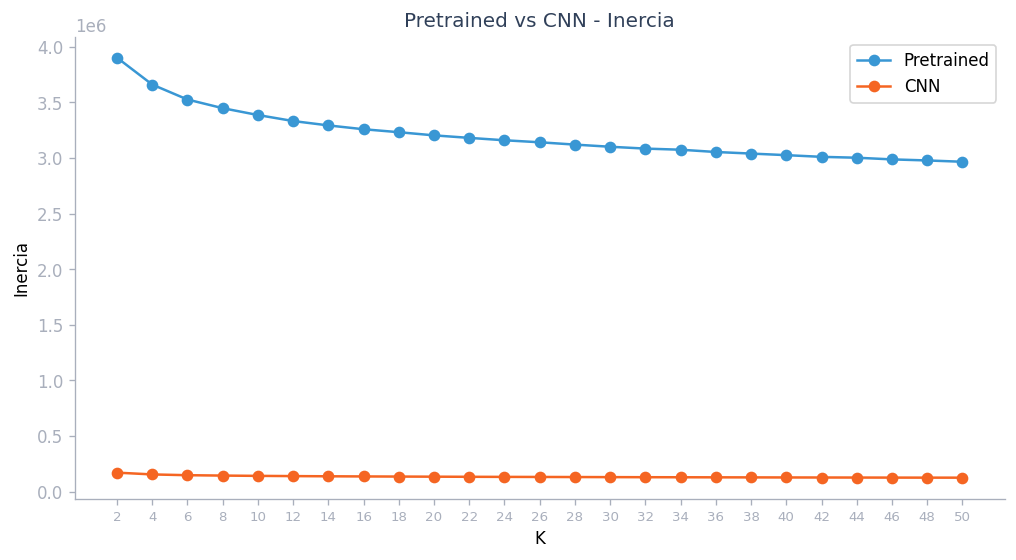

In [23]:
#Graficando inercia de los dos experimentos
plt.figure(figsize=(10, 5))
truns = runs[runs["params.k"]%2 == 0]
k_values = truns["params.k"]
inertia_values = truns["metrics.inertia"]
plt.plot(k_values, inertia_values, marker="o", label="Pretrained", color = mClr)
k_values = runs_cnn["params.k"]
inertia_values = runs_cnn["metrics.inertia"]
plt.plot(k_values, inertia_values, marker="o", label="CNN", color = sClr3)
plt.title("Pretrained vs CNN - Inercia")
plt.xlabel("K")
plt.ylabel("Inercia")
plt.legend()
kticks = [i for i in k_values if i % 2 == 0]
plt.xticks(fontsize=8)
plt.xticks(kticks)
plt.show()

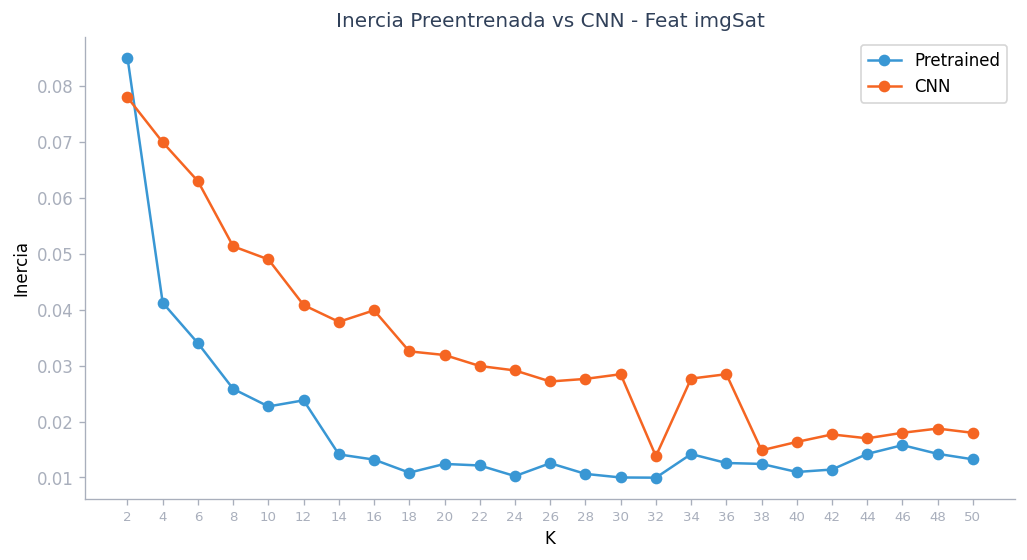

In [24]:
#Graficando inercia de los dos experimentos
plt.figure(figsize=(10, 5))
k_values = truns["params.k"]
inertia_values = truns["metrics.silhouette"]
plt.plot(k_values, inertia_values, marker="o", label="Pretrained", color = mClr)
k_values = runs_cnn["params.k"]
inertia_values = runs_cnn["metrics.silhouette"]
plt.plot(k_values, inertia_values, marker="o", label="CNN", color = sClr3)
plt.title("Inercia Preentrenada vs CNN - Feat imgSat")
plt.xlabel("K")
plt.ylabel("Inercia")
plt.legend()
kticks = [i for i in k_values if i % 2 == 0]
plt.xticks(fontsize=8)
plt.xticks(kticks)
plt.show()

Es importante considerar que la gráfica anterior no compara dos modelos entrenados con un mismo conjunto de datos, sino dos modelos distintos entrenado cada uno con su correspondiente conjunto de datos. Eso significa que a pesar de una métrica mejor para el modelo CNN, la revisión final de los clusters demuestra que el modelo pre-entrenado cumplió de mejor forma la tarea esperada.

## Característica Color Moments

La característica del modelo pre-entrenado así como sus clusters generados son nuevas características que pueden ser utilizadas para entrenar los modelos que atiendan al problema de estudio. En el caso de la dimensionadlidad del modelo preentrenado sigue siendo alta, y utilizar los clusters de baja dimensionadlidad implicaría solo usar el resultado de un modelo para entrenar y no una característica directamente extraída de la fuente original.

En la literatura se encontró el método color moments, que corresponde a representar las imágenes por medio de sus tres primeros momentos en cada color, lo que acaba con una dimensionalidad de 9, que es significativamente menor que las dos características anteriores.

In [279]:
def calculate_color_moments(image):
    #Convertir a float para evitar problemas de overflow en la potenciación
    image = image.astype('float32')
    moments = {}
    for i, channel_color in enumerate(['R', 'G', 'B']):
        channel_data = image[:, :, i]
        mean = np.mean(channel_data)
        variance = np.var(channel_data)
        skewness = np.mean((channel_data - mean)**3)
        moments[f'{channel_color}_mean'] = mean
        moments[f'{channel_color}_variance'] = variance
        moments[f'{channel_color}_skewness'] = skewness
    return moments

In [280]:
#Almacenando característica y nombres
all_batches_color_moments = []
names_color_moments = []

#Iterando batch dataset
for batch in dataset_with_path.take(num_batches_to_process):
    batch_color_moments = []
    
    for count, img in enumerate(batch[0]):
        #Convertir la imagen a un array NumPy
        img_numpy = img.numpy()
        
        #Calculando momentos
        color_moments = calculate_color_moments(img_numpy)
        
        #Agregando momentos y nombre
        batch_color_moments.append(color_moments)
        tempName = batch[1][count].numpy()
        tempName = tempName.decode("utf-8")
        tempName = tempName.split("/")[-1]
        names_color_moments.append(tempName)
    
    all_batches_color_moments.append(batch_color_moments)

first_image_first_batch_moments = all_batches_color_moments[0][0]
print(f"Color moments of the first image in the first batch: {first_image_first_batch_moments}")

Color moments of the first image in the first batch: {'R_mean': 0.49399564, 'R_variance': 0.07961397, 'R_skewness': -0.00031858648, 'G_mean': 0.49824786, 'G_variance': 0.08030854, 'G_skewness': -0.000114252536, 'B_mean': 0.49363008, 'B_variance': 0.08350188, 'B_skewness': 1.59477e-05}


In [281]:
color_moments = np.concatenate(all_batches_color_moments)
df_color_moments = pd.DataFrame(list(color_moments))
df_color_moments.to_csv("../../Data/DataMart/ImageViews/colorMoments.csv")
#df_color_moments.to_parquet("../../Data/DataMart/ImageViews/colorMoments.parquet")
df_color_moments.head()

R_mean  R_variance  R_skewness    G_mean  G_variance  G_skewness  \
0  0.493996    0.079614   -0.000319  0.498248    0.080309   -0.000114   
1  0.496694    0.080613   -0.001079  0.500900    0.079118    0.000208   
2  0.498071    0.077419   -0.000710  0.502380    0.077117   -0.000365   
3  0.495290    0.079155   -0.000054  0.499803    0.079683   -0.000204   
4  0.494792    0.078724   -0.000407  0.499935    0.079749   -0.000310   

     B_mean  B_variance  B_skewness  
0  0.493630    0.083502    0.000016  
1  0.500418    0.084725   -0.000353  
2  0.495800    0.082375   -0.000405  
3  0.495802    0.082194   -0.000137  
4  0.494976    0.083601   -0.000059

In [282]:
df_color_moments_with_path = df_color_moments.copy()
df_color_moments_with_path['imageName'] = names_color_moments
#df_color_moments_with_path.to_csv("../../Data/DataMart/ImageViews/colorMoments_with_path_2.csv")
#df_color_moments.to_parquet("../../Data/DataMart/ImageViews/colorMoments.parquet")
df_color_moments_with_path.head()

R_mean  R_variance  R_skewness    G_mean  G_variance  G_skewness  \
0  0.493996    0.079614   -0.000319  0.498248    0.080309   -0.000114   
1  0.496694    0.080613   -0.001079  0.500900    0.079118    0.000208   
2  0.498071    0.077419   -0.000710  0.502380    0.077117   -0.000365   
3  0.495290    0.079155   -0.000054  0.499803    0.079683   -0.000204   
4  0.494792    0.078724   -0.000407  0.499935    0.079749   -0.000310   

     B_mean  B_variance  B_skewness         imageName  
0  0.493630    0.083502    0.000016  satImg-19511.jpg  
1  0.500418    0.084725   -0.000353  satImg-18781.jpg  
2  0.495800    0.082375   -0.000405  satImg-16653.jpg  
3  0.495802    0.082194   -0.000137  satImg-11451.jpg  
4  0.494976    0.083601   -0.000059  satImg-11594.jpg

In [29]:
#Leyendo característica color moments
df_color_moments = pd.read_parquet("../../Data/DataMart/ImageViews/colorMoments.parquet")
df_color_moments_with_path = pd.read_csv("../../Data/DataMart/ImageViews/colorMoments_with_path_2.csv")
names_color_moments = df_color_moments_with_path["imageName"].values

In [ ]:
#Entrenando knn con características de color moments

cm_kmeans = KMeans(n_clusters=5, random_state=1010)
cm_clusters = cm_kmeans.fit_predict(df_color_moments)



In [284]:
#Cluster de color moments
image_clusters_cm = list(zip(names_color_moments, cm_clusters))

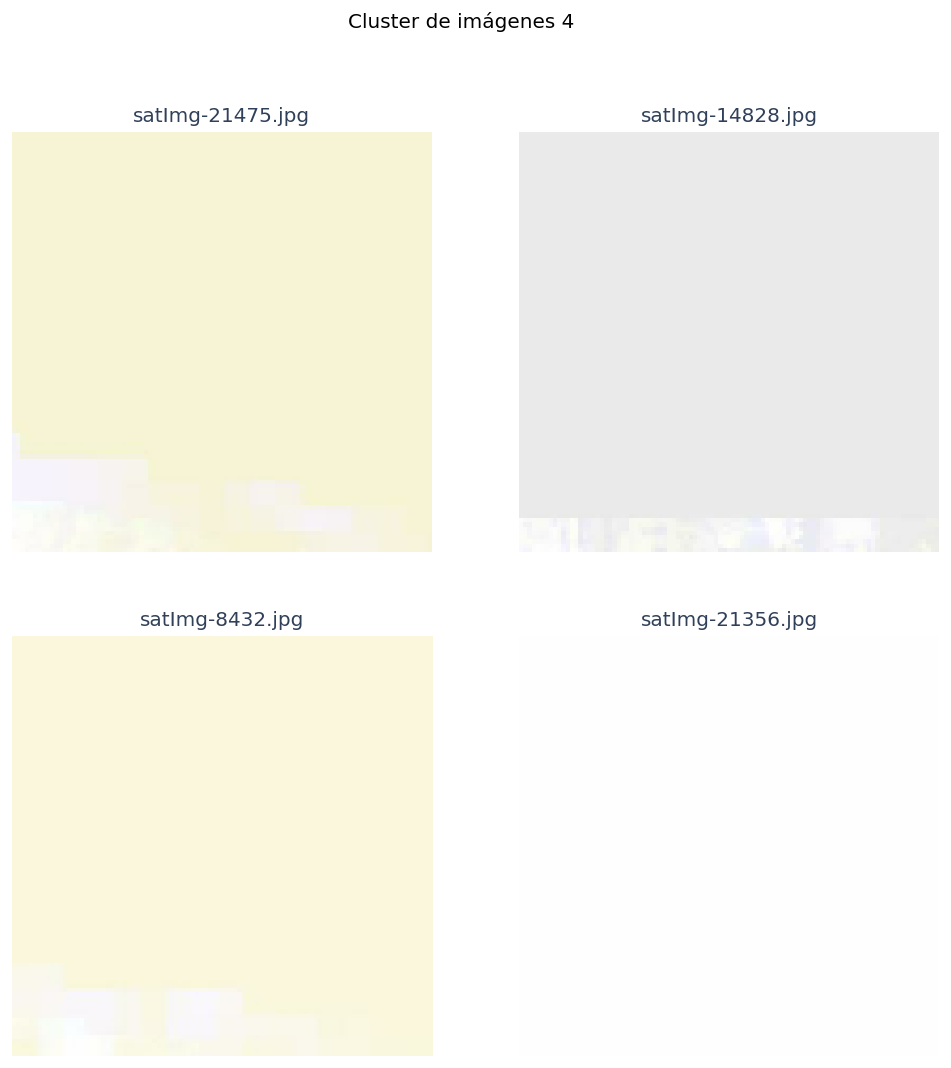

In [297]:
#Visualizando clusters
mostrar_imagenes_cluster(image_clusters_cm, 4)

### Encontrando K óptimo para Color Moments

In [ ]:
mlflow.set_experiment("OptimalK_ColorMoments")

#Probando con K de 2 a 50 clusters cada 2
k_values = range(2, 51, 2)
for k in k_values:
    currentTime = currentTime = datetime.now().strftime(RUN_BASE_FORMAT)
    mlflow.start_run(run_name = currentTime)
    kmeans_cm = KMeans(n_clusters=k, random_state=1010)
    kmeans_cm.fit(df_color_moments)
    mlflow.log_param("k", k)
    mlflow.log_metric("inertia", kmeans_cm.inertia_)
    mlflow.log_metric("silhouette", silhouette_score(df_color_moments, kmeans_cm.labels_))
    mlflow.end_run()

In [25]:
#Obteniendo registros de corrida
experiment_id = mlflow.get_experiment_by_name("OptimalK_ColorMoments").experiment_id
runs_cm = mlflow.search_runs(experiment_ids=experiment_id)
runs_cm.head()

run_id       experiment_id    status  \
0  0bdd9746e8d847ca953ee8abffe4a40d  775480602452446902  FINISHED   
1  37005a10fba2412eb44e3b9fffe173b5  775480602452446902  FINISHED   
2  c20a15aa5b284a918cd364bce119bced  775480602452446902  FINISHED   
3  990b98842dbe457ea9c59ab69ce518bd  775480602452446902  FINISHED   
4  c52eeb8e8a9d4f8abfe76eb27f695ef0  775480602452446902  FINISHED   

                                        artifact_uri  \
0  file:///Users/victor.borrayo/Desktop/Tesis/tra...   
1  file:///Users/victor.borrayo/Desktop/Tesis/tra...   
2  file:///Users/victor.borrayo/Desktop/Tesis/tra...   
3  file:///Users/victor.borrayo/Desktop/Tesis/tra...   
4  file:///Users/victor.borrayo/Desktop/Tesis/tra...   

                        start_time                         end_time  \
0 2024-03-05 01:34:35.842000+00:00 2024-03-05 01:34:42.600000+00:00   
1 2024-03-05 01:34:29.203000+00:00 2024-03-05 01:34:35.840000+00:00   
2 2024-03-05 01:34:22.413000+00:00 2024-03-05 01:34:29.202000+00:00   
3 2024-03-05 01:34:15.327000+00:00 2024-03-05 01:34:22.411000+00:00   
4 2024-03-05 01:34:08.355000+00:00 2024-03-05 01:34:15.326000+00:00   

   metrics.silhouette  metrics.inertia params.k  \
0            0.161177         0.104618       50   
1            0.164375         0.109429       48   
2            0.169815         0.112995       46   
3            0.162746         0.117578       44   
4            0.170954         0.121700       42   

                             tags.mlflow.source.name tags.mlflow.source.type  \
0  /Users/victor.borrayo/anaconda3/envs/Tesis/lib...                   LOCAL   
1  /Users/victor.borrayo/anaconda3/envs/Tesis/lib...                   LOCAL   
2  /Users/victor.borrayo/anaconda3/envs/Tesis/lib...                   LOCAL   
3  /Users/victor.borrayo/anaconda3/envs/Tesis/lib...                   LOCAL   
4  /Users/victor.borrayo/anaconda3/envs/Tesis/lib...                   LOCAL   

  tags.mlflow.user  tags.mlflow.runName  
0   victor.borrayo  2024-03-04_19-34-35  
1   victor.borrayo  2024-03-04_19-34-29  
2   victor.borrayo  2024-03-04_19-34-22  
3   victor.borrayo  2024-03-04_19-34-15  
4   victor.borrayo  2024-03-04_19-34-08

Text(0.5, 1.0, 'Inercia vs. K - Color Moments')

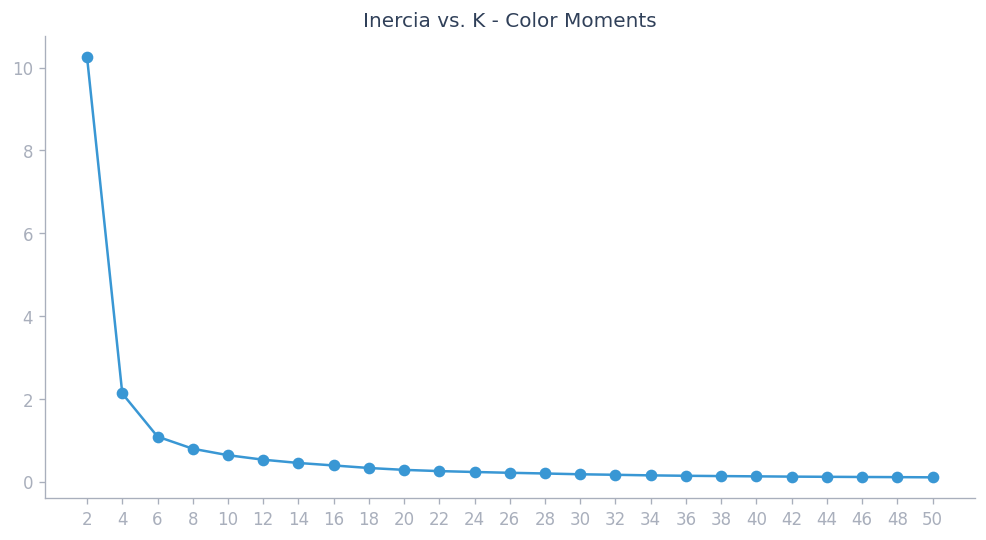

In [26]:
#Graficando inercia
runs_cm = runs_cm.dropna()
runs_cm["params.k"] = runs_cm["params.k"].astype(int)
runs_cm = runs_cm.sort_values(by="params.k")
k_values = runs_cm["params.k"]
inertia_values = runs_cm["metrics.inertia"].astype(float)
k_sticks = [i for i in k_values if i % 2 == 0]
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_values, marker="o", color = mClr)
plt.xticks(k_sticks)
plt.title("Inercia vs. K - Color Moments")

Text(0.5, 1.0, 'Silueta vs. K - Color Moments')

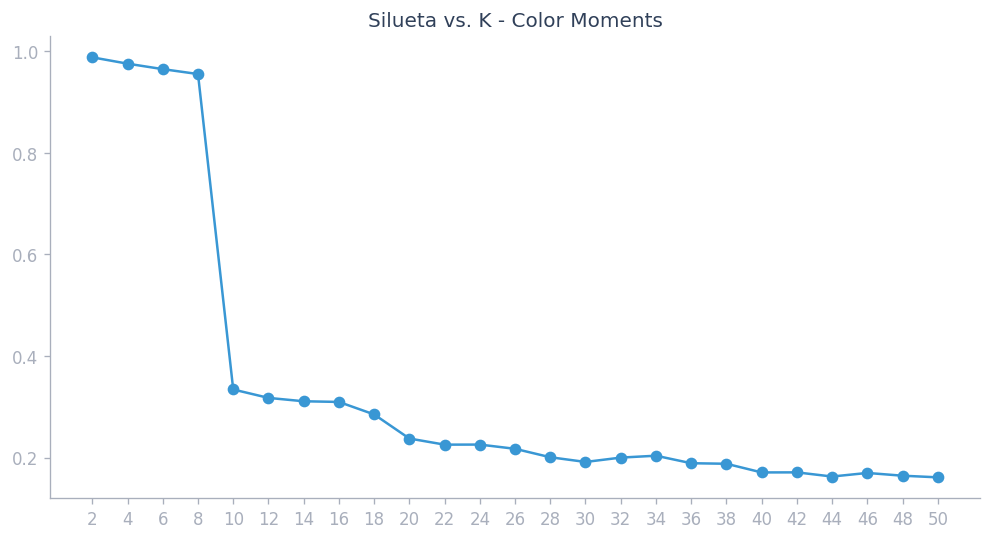

In [27]:
#Graficando silueta
runs_cm = runs_cm.dropna()
runs_cm["params.k"] = runs_cm["params.k"].astype(int)
runs_cm = runs_cm.sort_values(by="params.k")
k_values = runs_cm["params.k"]
silueta_values = runs_cm["metrics.silhouette"].astype(float)
k_sticks = [i for i in k_values if i % 2 == 0]
plt.figure(figsize=(10, 5))
plt.plot(k_values, silueta_values, marker="o", color = mClr)
plt.xticks(k_sticks)
plt.title("Silueta vs. K - Color Moments")

Por fin se puede apreciar un códo, como decisión de diseño se elije el 8 como el K óptimo, y a partir de ahí se procede. Las cotas del valor de la inercia también son resaltables y su justificación está, según un análisis simple, en la dimensionalidad de esta característica.

In [ ]:
#Entrenando con K óptimo
k_cm = 8
kmeans_cm = KMeans(n_clusters=k_cm, random_state=1010)
cm_clusters = kmeans_cm.fit_predict(df_color_moments)


In [31]:
image_clusters_cm = list(zip(names_color_moments, cm_clusters))

<AxesSubplot: title={'center': 'Clusters Kmeans Color Moments - k=8'}>

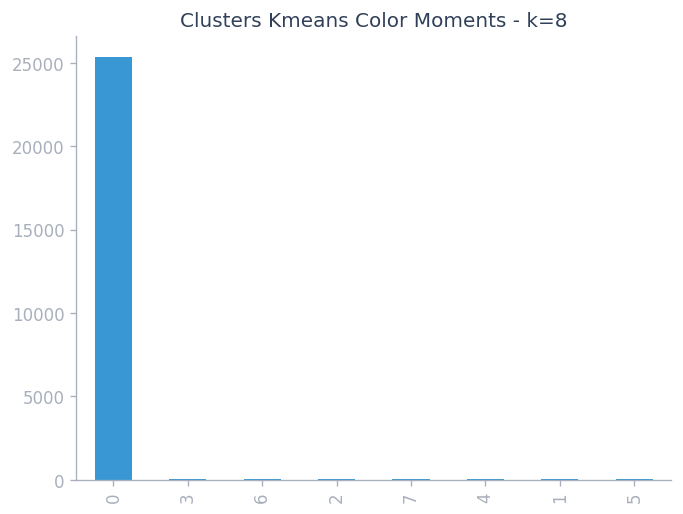

In [32]:
#Visualizando histograma de clusters
tdf_cm = pd.DataFrame(image_clusters_cm, columns = ["imgName","cluster"])
tdf_cm["cluster"].value_counts().plot(kind = "bar", title="Clusters Kmeans Color Moments - k=8", color = mClr)

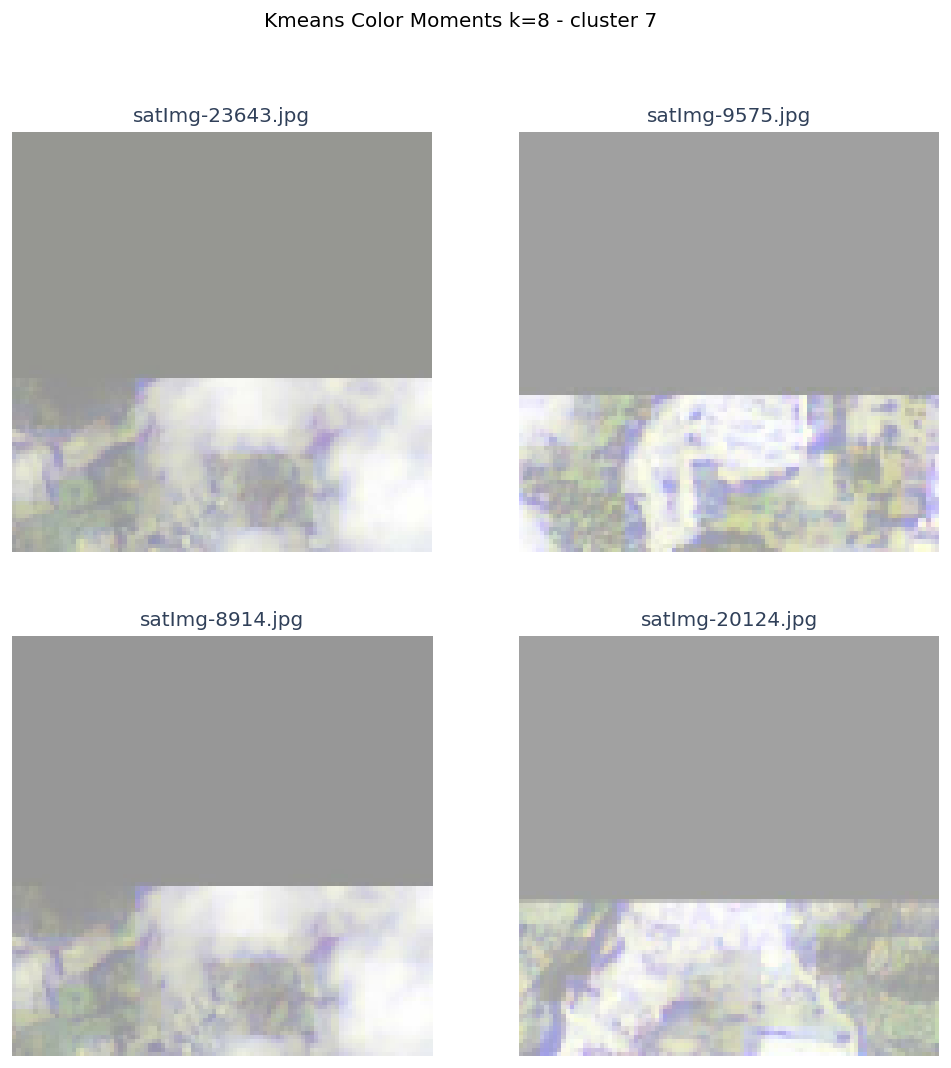

In [573]:
#Visualizando imageclusters cm
mostrar_imagenes_cluster(image_clusters_cm, 7, "Kmeans Color Moments k=8 - cluster")

Se aprecia que la característica Color Moments tiene sensibilidad a los outliers al hacer uso del algoritmo Kmeans. Las anomalías se están identificando, posiblemente por la poca variabilidad de estas imágenes, sin embargo las diferencias en los colores están siendo segmentadas en distintos clusters, a diferencia de cuando se usa la característica Pre-entrenada. Por tal motivo se utilizará un algoritmo de detección de anomalías con esta característica.

In [33]:
#Identificando anomalías con Isolation Forest

#Entrenando el modelo Isolation Forest
iforest = IsolationForest(contamination=0.01, random_state=1010)
iforest.fit(df_color_moments)

IsolationForest(contamination=0.01, random_state=1010)

In [34]:
#Predicción de anomalías

anomaly_measure = iforest.predict(df_color_moments)
#Cluster de imagenes con Isolation Forest
image_clusters_iforest_cm = list(zip(names_color_moments, anomaly_measure))

<AxesSubplot: title={'center': 'Histograma Isolation Forest - Color Moments'}, ylabel='Frequency'>

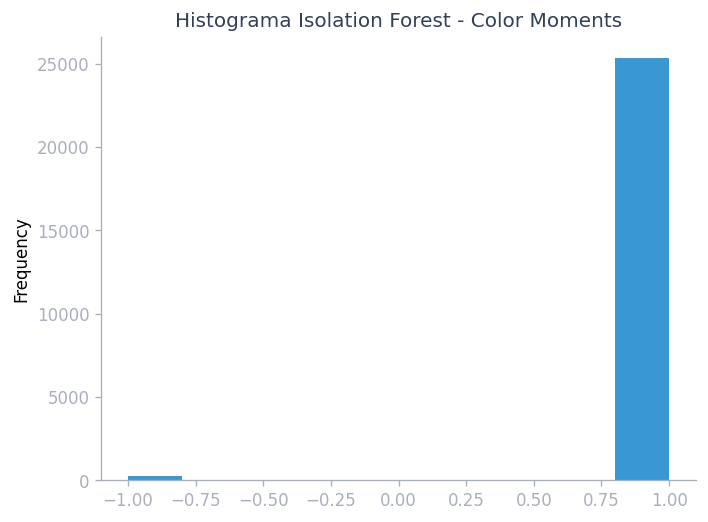

In [35]:
#Visualizando histograma de clusters
tdf_iforest = pd.DataFrame(image_clusters_iforest_cm, columns = ["imgName","anomaly"])
tdf_iforest["anomaly"].plot(kind = "hist", title = "Histograma Isolation Forest - Color Moments", color = mClr)

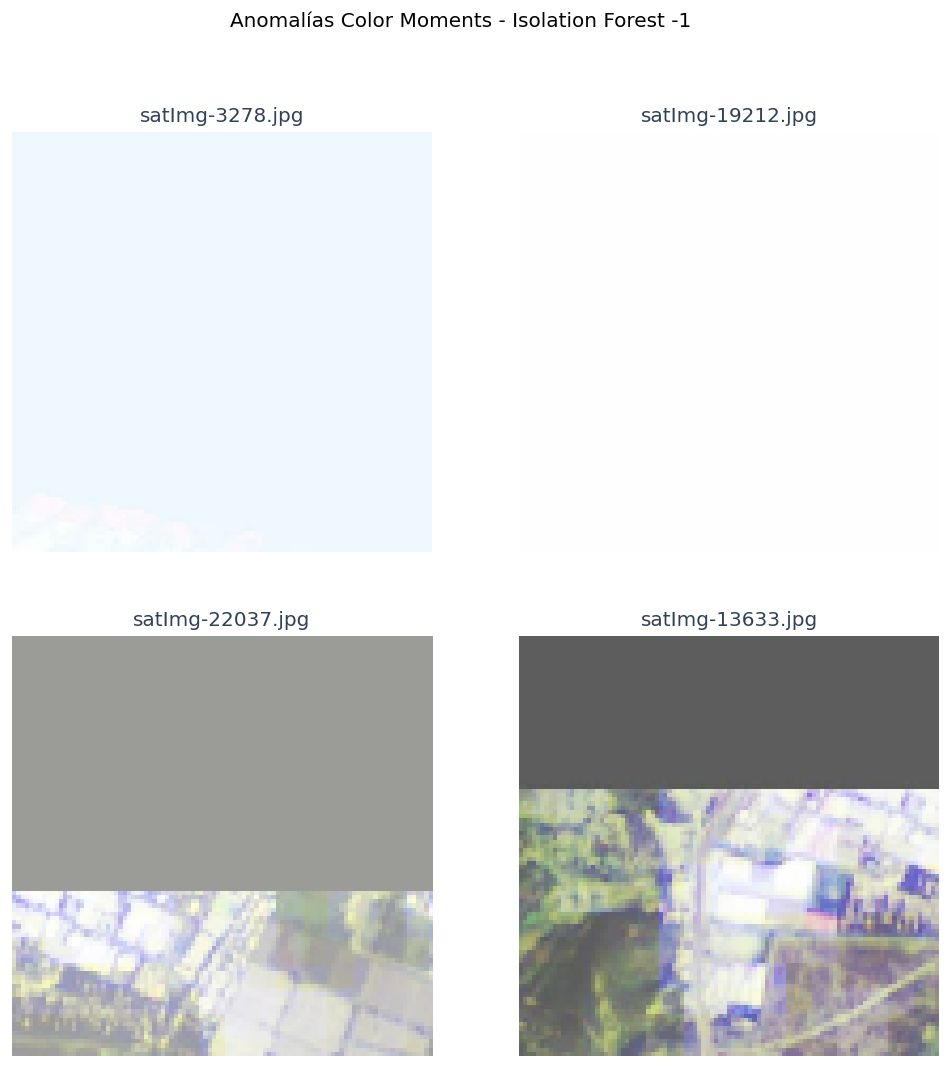

In [37]:
#Visualizando anomalías
mostrar_imagenes_cluster(image_clusters_iforest_cm, -1, "Anomalías Color Moments - Isolation Forest")

In [38]:
#Creando df sin anomalías

df_color_moments_no_anomalies = df_color_moments[anomaly_measure == 1]
total_anomalies_if_cm = len(df_color_moments) - len(df_color_moments_no_anomalies)
total_anomalies_if_cm

254

In [39]:
#Lista de anomalías con Iforest y Color Moments
anomalies_iforest_cm = tdf_iforest[tdf_iforest["anomaly"] == -1]["imgName"].values.tolist()

### Entrenando Kmeans sin anomalías

In [ ]:
#Entrenando knn con color moments sin anomalías
k_cm = 8
kmeans_cm_na = KMeans(n_clusters=k_cm, random_state=1010)
cm_clusters_na = kmeans_cm_na.fit_predict(df_color_moments_no_anomalies)

<AxesSubplot: title={'center': 'Clusters Kmeans Color Moments sin anomalías - k=12'}>

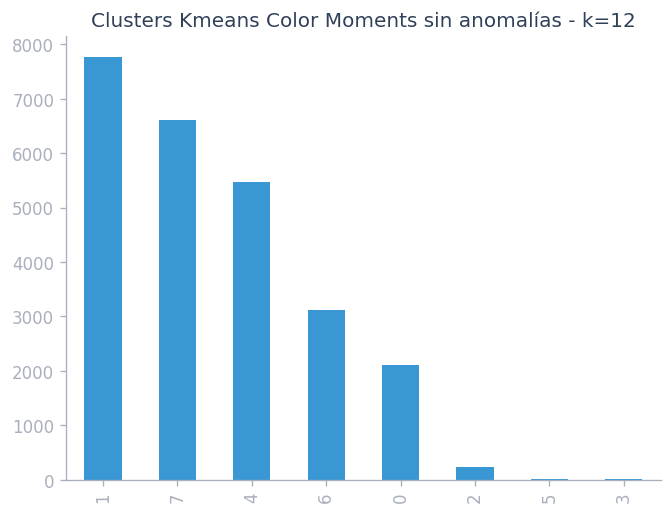

In [41]:
#Histograma
tdf_cm_na = pd.DataFrame(cm_clusters_na, columns = ["cluster"])
tdf_cm_na["cluster"].value_counts().plot(kind = "bar", color = mClr, title="Clusters Kmeans Color Moments sin anomalías - k=12")

In [43]:
#Imageclusters para cm sin anomalías
image_clusters_cm_na = list(zip(names_color_moments, cm_clusters_na))

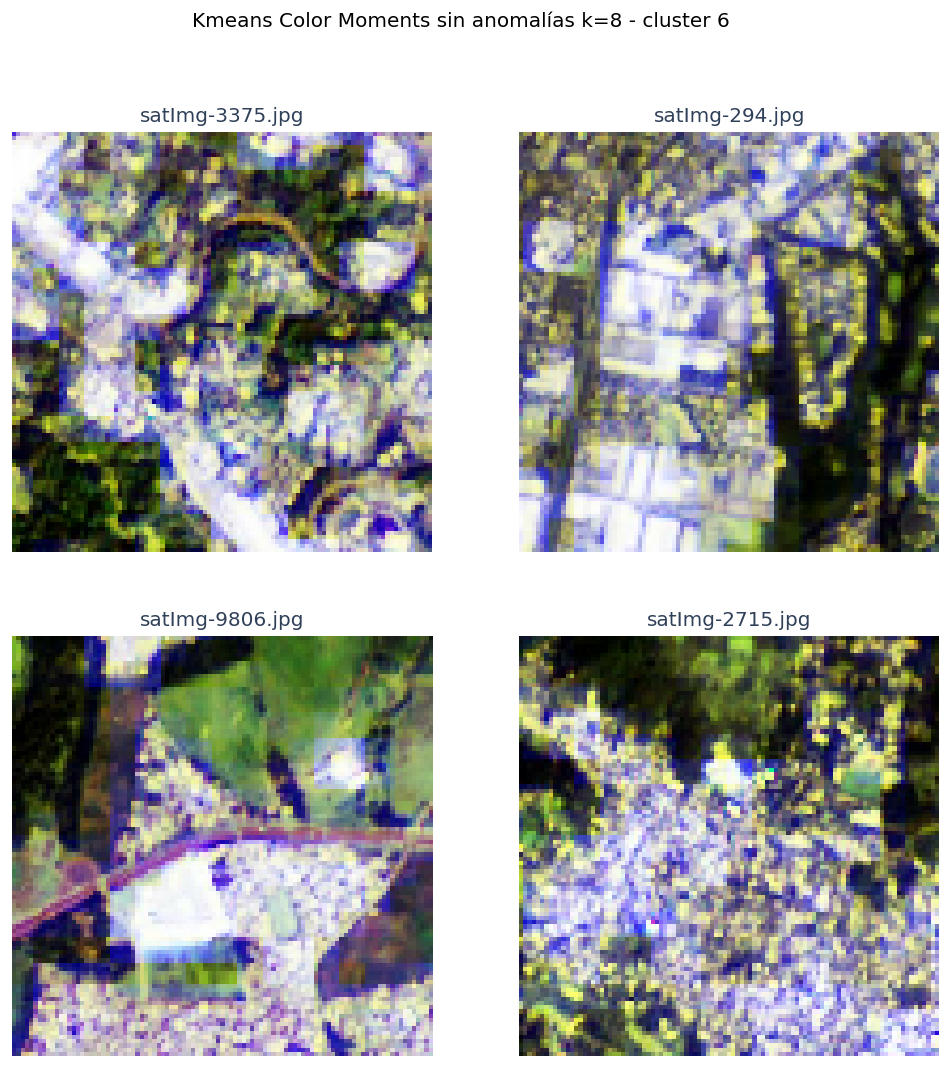

In [44]:
#Visualizando imageclusters cm sin anomalías
mostrar_imagenes_cluster(image_clusters_cm_na, 6, "Kmeans Color Moments sin anomalías k=8 - cluster")

Incluso con la simplicidad de la característica, la calidad mejoró luego de retirar las anomalías. Se compara a continuación el tamaño de las anomalías identificadas por el cluster 2 al utilizar la característica Pre-entrenada y por el modelo Isolation Forest con la característica Kmeans.

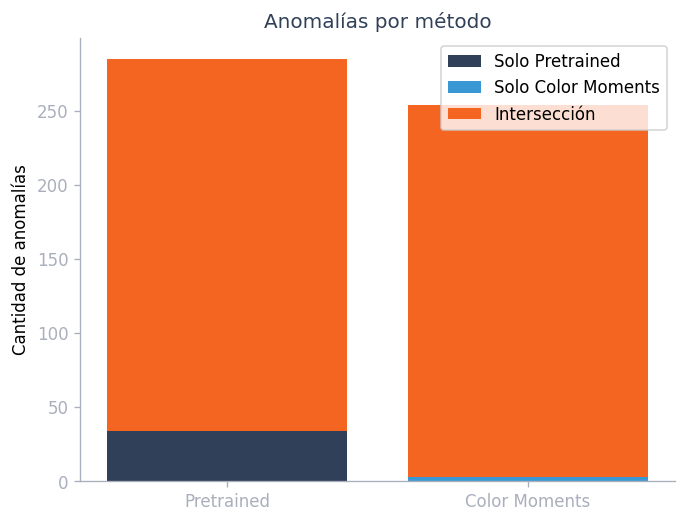

In [47]:
#Visualizando anomalías con dos métodos
intersection_anomalies = list(set(anomalies_cluster_2_ptr).intersection(anomalies_iforest_cm))
just_ptr_anomalies = list(set(anomalies_cluster_2_ptr).difference(anomalies_iforest_cm))
just_cm_anomalies = list(set(anomalies_iforest_cm).difference(anomalies_cluster_2_ptr))

total_intersection = len(intersection_anomalies)
total_just_ptr = len(just_ptr_anomalies)
total_just_cm = len(just_cm_anomalies)

#Gráfica de barras apiladas
methods = ["Pretrained", "Color Moments"]
barra_ptr = [total_just_ptr, 0]
barra_cm = [0, total_just_cm]

fig, ax = plt.subplots()
ax.bar(methods, barra_ptr, color = sClr1, label='Solo Pretrained')
ax.bar(methods, barra_cm, label = "Solo Color Moments", color = mClr)
ax.bar(methods, [total_intersection, total_intersection], bottom=[barra_ptr[0], barra_cm[1]], label = "Intersección", color = sClr3)

ax.set_ylabel('Cantidad de anomalías')
ax.set_title('Anomalías por método')
ax.legend()
plt.show()

Según lo anterior se decide utilizar el cluster 2 de Kmeans al utilizar el modelo Pre-entrenado para identificar anomalías en el dataset de imágenes.